# Leveraging Student Information to Enhance College Persistence with 4-Year Data

### Step 1: Read the Data

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#Read dataset
df = pd.read_excel('data/FY23 data pull.xlsx')
df.head()
df.shape

,Updated ID,High School,HS Grad Year,HS Grad Date,Months Since HS Grad Date,Program Participation,HS GPA Unweighted,HS GPA Weighted,Dual Enrolled,Home Language,ELL/ESL,Gender,Low Income,Race Ethnicity,SAT Composite,ACT Composite,% of scholarships not accepted,Transfer status,2-yr/4-yr start,HS Region,# of scholarships since 2015,Degree Goal,State Preference,Institution Type Preference,First College Enrollment Date,Months Until FCE,First College Name,First College Type,Highest Degree Earned,Highest Degree College Name,Highest Degree Date,First Cert Date,First 2-Year Degree Date,First 4-Year Degree Date,First Advanced Degree Date,2-Year College First Enrollment Date,Months Since First 2-Yr Enrollment,2-Year Degree Date,4-Year Degree Prior to 2-Year Enrollment,4-Year College First Enrollment Date,Months Since First 4-Yr Enrollment,4-Year Degree Date,Time from HS grad to bachelors,6 year BA attainment,8 year BA attainment,Enrollment Indicator Name,Enrollment Indicator,Latest enrollment,Persistence Indicator Name,Persistence Indicator,Completion Indicator Name,Completion Indicator,Associate Completion Indicator Name,Associate Completion Indicator,Bachelors Completion Indicator Name,Bachelors Completion Indicator,Retention Indicator Name,Retention Indicator
0,1,Ida B. Wells Continuation High School,2020,2020-06-01,26,"Scholarship post 2015, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Black/African American,NaN,NaN,-67%,No,Never Enrolled,SF Region,2.0,NaN,NaN,NaN,NaT,NaN,Never Enrolled,Never Enrolled,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,0,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
1,2,San Rafael High School,2020,2020-06-01,26,"Scholarship post 2015, Institute, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-60%,No,2-Year,Marin,2.0,NaN,NaN,NaN,2022-01-22,19.677419,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2022-01-22,10.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,20220822,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
2,3,Non-Partner School,2009,2009-06-01,158,"Success, Scholarship",NaN,NaN,No,NaN,Not Provided,Female,Yes,Multiracial/Multiethnic,NaN,NaN,-39%,No,2-Year,Sonoma,4.0,NaN,NaN,NaN,2010-06-14,12.419355,Santa Barbara City College,2-Year,Certificate,Santa Rosa Junior College,2018-05-01,2018-05-01,NaT,NaT,NaT,2010-06-14,149.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,20220815,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,Yes,Associate Completion w/in 3 Years,No,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
3,4,Novato High School,2021,2021-06-01,14,"Scholarship post 2015, Institute",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-100%,No,Never Enrolled,Marin,1.0,NaN,NaN,NaN,NaT,NaN,Never Enrolled,Never Enrolled,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,0,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
4,5,San Rafael High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-83%,No,2-Year,Marin,3.0,NaN,NaN,NaN,2019-08-19,2.580645,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,Yes,20190819,Persistence Fall 1 to Fall 2,No,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,No,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,No


(9945, 58)

In [3]:
#Check the variable type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 58 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Updated ID                                9945 non-null   int64         
 1   High School                               9945 non-null   object        
 2   HS Grad Year                              9945 non-null   int64         
 3   HS Grad Date                              9945 non-null   datetime64[ns]
 4   Months Since HS Grad Date                 9945 non-null   int64         
 5   Program Participation                     8337 non-null   object        
 6   HS GPA Unweighted                         0 non-null      float64       
 7   HS GPA Weighted                           0 non-null      float64       
 8   Dual Enrolled                             9945 non-null   object        
 9   Home Language                 

In [4]:
#Check to see if there are any duplicates based on match key
df.shape[0] - df['Updated ID'].nunique()

0

### Step 2: Clean-up the Data

#### Drop columns with no data that can be used for modeling

In [5]:
#Identify columns with all null or just one value
colToDrop = []

for col in list(df.columns):
    if (df[col].nunique() <= 1):
        colToDrop.append(col)
        
colToDrop

['HS GPA Unweighted',
 'HS GPA Weighted',
 'Home Language',
 'ELL/ESL',
 'Low Income',
 'SAT Composite',
 'ACT Composite',
 'Degree Goal',
 'State Preference',
 'Institution Type Preference',
 '6 year BA attainment',
 '8 year BA attainment',
 'Enrollment Indicator Name',
 'Persistence Indicator Name',
 'Completion Indicator Name',
 'Associate Completion Indicator Name',
 'Bachelors Completion Indicator Name',
 'Retention Indicator Name']

In [6]:
#Drop columns from the dataframe
df = df.drop(columns = colToDrop)
df.shape

(9945, 40)

#### Drop records as exclusions per discussions with 10,000 Degrees

10,000 Degrees recommended applying the following exclusions to the data:

| #     | Variable Name |Description|Exclusion Criteria | Comment |
| :---        |    :----   |    :----   |   :---|   :---|
|1|Persistence Indicator|Indicator to identify students who persisted to the second year of college. This is also the targe variable.|Keep 'Yes' or 'No'|Remove 'Ineligible' students. Some of them took time off before starting college. We do not know if they persisted for their second year of college. They are indeterminates.|
|2|HS Grad Year|High school graduation year|Keep >=2010|Students graduated from high school before 2010 may not have reliable data.|
|3|Program Participation|Participated at any of the programs offered by 10,000 Degrees|Keep records with non-null values |Students with null values applied to a scholarship but were not awarded.|
|4|2-yr/4-yr start|Attended a 2 yr or 4 yr program|Keep records with non-null values |Students with null values have no enrollment information at National Student Clearinghouse (NSC).|

In [7]:
#Keep only records with "Persistence Indicator" is in ['Yes','No']. 
df['Persistence Indicator'].value_counts()

df = df[(df['Persistence Indicator'] == 'Yes') | (df['Persistence Indicator'] == 'No')]

print(f'There are {df.shape[0]} records with Persistence Indicator == "Yes" or "No".')

Ineligible    4955
Yes           4327
No             663
Name: Persistence Indicator, dtype: int64

There are 4990 records with Persistence Indicator == "Yes" or "No".


In [8]:
#Assign 'Persistence Indicator' to 0 (persist) and 1 (drop-out)
df['persistIndicator'] = df['Persistence Indicator'].map(lambda x: 1 if "No" in x else 0)
df['persistIndicator'].value_counts()

0    4327
1     663
Name: persistIndicator, dtype: int64

In [9]:
# Keep records with HS Grad Year >= 2010. Data before 2010 is not reliable.
df = df[(df['HS Grad Year'] >= 2010)]
print(f'There are {df.shape[0]} records with HS Grad Year >= 2010.')

There are 4975 records with HS Grad Year >= 2010.


In [10]:
#Exclude records with null values for Program Participation
df['Program Participation'].isnull().sum()
df = df[df['Program Participation'].isnull() == False]
print(f'There are {df.shape[0]} records with non-null Program Participation.')

312

There are 4663 records with non-null Program Participation.


In [11]:
#Exclude records with null values for 2-yr/4-yr start
df['2-yr/4-yr start'].isnull().sum()
df = df[df['2-yr/4-yr start'].isnull() == False]
print(f'There are {df.shape[0]} records with non-null 2-yr/4-yr start.')

0

There are 4663 records with non-null 2-yr/4-yr start.


### Step 3: Segment the data for 2-year and 4-year students

In [12]:
df.groupby('2-yr/4-yr start')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Drop-out Rate"})

,Count,Drop-out Rate
2-yr/4-yr start,,
2-Year,2018,0.239346
4-Year,2644,0.055219
Less than 2-Year,1,1.000000


- The drop-out rate for students attending 2-year college is significantly higher.
- Decided to segment the population into two groups: 2-year and 4-year.
- Will focus on the 4-Year data in this notebook. There is a separate notebook for the analysis on the 2-Year data.

In [13]:
#Keep only records with '2-yr/4-yr start' == 2-Year or Less than 2-Year
df = df[(df['2-yr/4-yr start'] == '4-Year')]
df.shape

(2644, 41)

In [14]:
#Calculate the final drop-out rate for the analysis sample
dropOutRate = df['persistIndicator'].value_counts(normalize=True)[1]
dropOutRate

0.05521936459909228

### Step 4: Feature Engineering

#### Analyze each column to decide on a treatment for 2-Year data

In [15]:
#Function to generate freq and drop-out rate charts
def histCatVariablesCount(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Number of Students", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation = 45,labelsize = '15')

def histCatVariablesNonPersistenceRate(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Drop-out Rate", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation= 45,labelsize = '15')
    ax[i].axhline(y = dropOutRate, color = 'r')
    ax[i].text(0, 0.058, "Average Drop-out Rate", fontsize = 15)

In [16]:
#List of columns that will be analyzed in this section
list(df.columns)

['Updated ID',
 'High School',
 'HS Grad Year',
 'HS Grad Date',
 'Months Since HS Grad Date',
 'Program Participation',
 'Dual Enrolled',
 'Gender',
 'Race Ethnicity',
 '% of scholarships not accepted',
 'Transfer status',
 '2-yr/4-yr start',
 'HS Region',
 '# of scholarships since 2015',
 'First College Enrollment Date',
 'Months Until FCE',
 'First College Name',
 'First College Type',
 'Highest Degree Earned',
 'Highest Degree College Name',
 'Highest Degree Date',
 'First Cert Date',
 'First 2-Year Degree Date',
 'First 4-Year Degree Date',
 'First Advanced Degree Date',
 '2-Year College First Enrollment Date',
 'Months Since First 2-Yr Enrollment',
 '2-Year Degree Date',
 '4-Year Degree Prior to 2-Year Enrollment',
 '4-Year College First Enrollment Date',
 'Months Since First 4-Yr Enrollment',
 '4-Year Degree Date',
 'Time from HS grad to bachelors',
 'Enrollment Indicator',
 'Latest enrollment',
 'Persistence Indicator',
 'Completion Indicator',
 'Associate Completion Indicator'

#### High School 

In [17]:
#Create a function to web scrape school ratings from greatschools.org website using BeautifulSoup
import requests
from bs4 import BeautifulSoup

def get_school_rating(school_name):
    url = f'https://www.greatschools.org/search/search.page?q={school_name}'
    response = requests.get(url, verify = False)
    html_data = response.text

    soup = BeautifulSoup(html_data, 'html.parser')
    cdata = soup.find('script')

    cdata_str = str(cdata)
    start = cdata_str.find('"rating":') + len('"rating":')
    end = cdata_str.find(',', start)
    rating = cdata_str[start:end].strip()
    if rating:
        return rating
    else:
        return "School not found"

In [18]:
#Create a unique list of high school names and their web addresses according to greatschools.org format
schoolList = list(df['High School'].unique())

formattedSchoolList = []

for school in schoolList:
    formattedSchool = "%22" + school.replace(" ","%20") +"%22" #Standard website link for each school name
    formattedSchoolList.append(formattedSchool)
    
schoolListDict = dict(zip(schoolList,formattedSchoolList))

In [19]:
#Create a dataframe with school names, websites and ratings.
schools = []
schoolsWebAddress = []
ratings = []

for key, value in schoolListDict.items():
    schools.append(key)
    schoolsWebAddress.append("https://www.greatschools.org/search/search.page?q="+value)
    rating = get_school_rating(value)
    if rating == "null": #The school does not have a rating
        rating = -1
    elif rating == '//<![CDATA[\nwindow.gon={};gon.ad_set_targeting={"env":"prod"': #The link is not working
        rating = -2
    else:
        rating = int(rating)-1
    rating = str(rating)
    ratings.append(rating)

dfSchoolRating = pd.DataFrame({'School': schools, 'Web Address': schoolsWebAddress, 'HSRating': ratings})
dfSchoolRating.head()

,School,Web Address,HSRating
0,San Rafael High School,https://www.greatschools.org/search/search.pag...,3
1,Sonoma Valley High School,https://www.greatschools.org/search/search.pag...,4
2,Tamalpais High School,https://www.greatschools.org/search/search.pag...,8
3,Terra Linda High School,https://www.greatschools.org/search/search.pag...,5
4,Thurgood Marshall High School,https://www.greatschools.org/search/search.pag...,-1


In [20]:
#Merge df with dfSchoolRating to get their HS school rating by doing a left join
df = pd.merge(left = df, right = dfSchoolRating[['School','HSRating']], left_on = 'High School', right_on = 'School', how = 'left').drop(columns = ['School'])
df.head()

,Updated ID,High School,HS Grad Year,HS Grad Date,Months Since HS Grad Date,Program Participation,Dual Enrolled,Gender,Race Ethnicity,% of scholarships not accepted,Transfer status,2-yr/4-yr start,HS Region,# of scholarships since 2015,First College Enrollment Date,Months Until FCE,First College Name,First College Type,Highest Degree Earned,Highest Degree College Name,Highest Degree Date,First Cert Date,First 2-Year Degree Date,First 4-Year Degree Date,First Advanced Degree Date,2-Year College First Enrollment Date,Months Since First 2-Yr Enrollment,2-Year Degree Date,4-Year Degree Prior to 2-Year Enrollment,4-Year College First Enrollment Date,Months Since First 4-Yr Enrollment,4-Year Degree Date,Time from HS grad to bachelors,Enrollment Indicator,Latest enrollment,Persistence Indicator,Completion Indicator,Associate Completion Indicator,Bachelors Completion Indicator,Retention Indicator,persistIndicator,HSRating
0,23,San Rafael High School,2017,2017-06-01,62,Scholarship,No,Female,Hispanic/Latino/a/x,-37%,No,4-Year,Marin,5.0,2017-08-23,2.709677,San Francisco State University,4-Year,2-Year,Contra Costa College,2020-05-22,NaT,2020-05-22,NaT,NaT,2019-05-28,42.0,2020-05-22,No,2017-08-23,63.0,NaT,NaN,Yes,20220819,Yes,Yes,Yes,Ineligible,Yes,0,3
1,28,Sonoma Valley High School,2021,2021-06-01,14,"Scholarship post 2015, Institute",No,Female,Hispanic/Latino/a/x,0%,No,4-Year,Sonoma,1.0,2021-08-30,2.935484,College Of Southern Nevada,4-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2022-01-19,10.0,NaT,No,2021-08-30,15.0,NaT,NaN,Yes,20220815,Yes,No,Ineligible,Ineligible,No,0,4
2,32,Tamalpais High School,2019,2019-06-01,38,Scholarship post 2015,No,Female,Not Provided,-75%,No,4-Year,Marin,2.0,2019-09-03,3.064516,Hampton University,4-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,2019-09-03,38.0,NaT,NaN,Yes,20200109,No,No,Ineligible,Ineligible,No,1,8
3,34,Terra Linda High School,2017,2017-06-01,62,"Scholarship post 2015, Institute, Success",No,Female,Hispanic/Latino/a/x,-35%,No,4-Year,Marin,5.0,2017-08-28,2.870968,California State University - Sacramento,4-Year,Certificate,Santa Rosa Junior College,2019-12-01,2019-12-01,NaT,NaT,NaT,2018-01-17,58.0,NaT,No,2017-08-28,63.0,NaT,NaN,Yes,20220822,Yes,Yes,No,Ineligible,No,0,5
4,35,Thurgood Marshall High School,2021,2021-06-01,14,Scholarship post 2015,No,Male,Hispanic/Latino/a/x,-100%,No,4-Year,SF Region,1.0,2021-06-01,0.000000,San Francisco State University,4-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,2021-06-01,17.0,NaT,NaN,Yes,20220822,Yes,No,Ineligible,Ineligible,Yes,0,-1


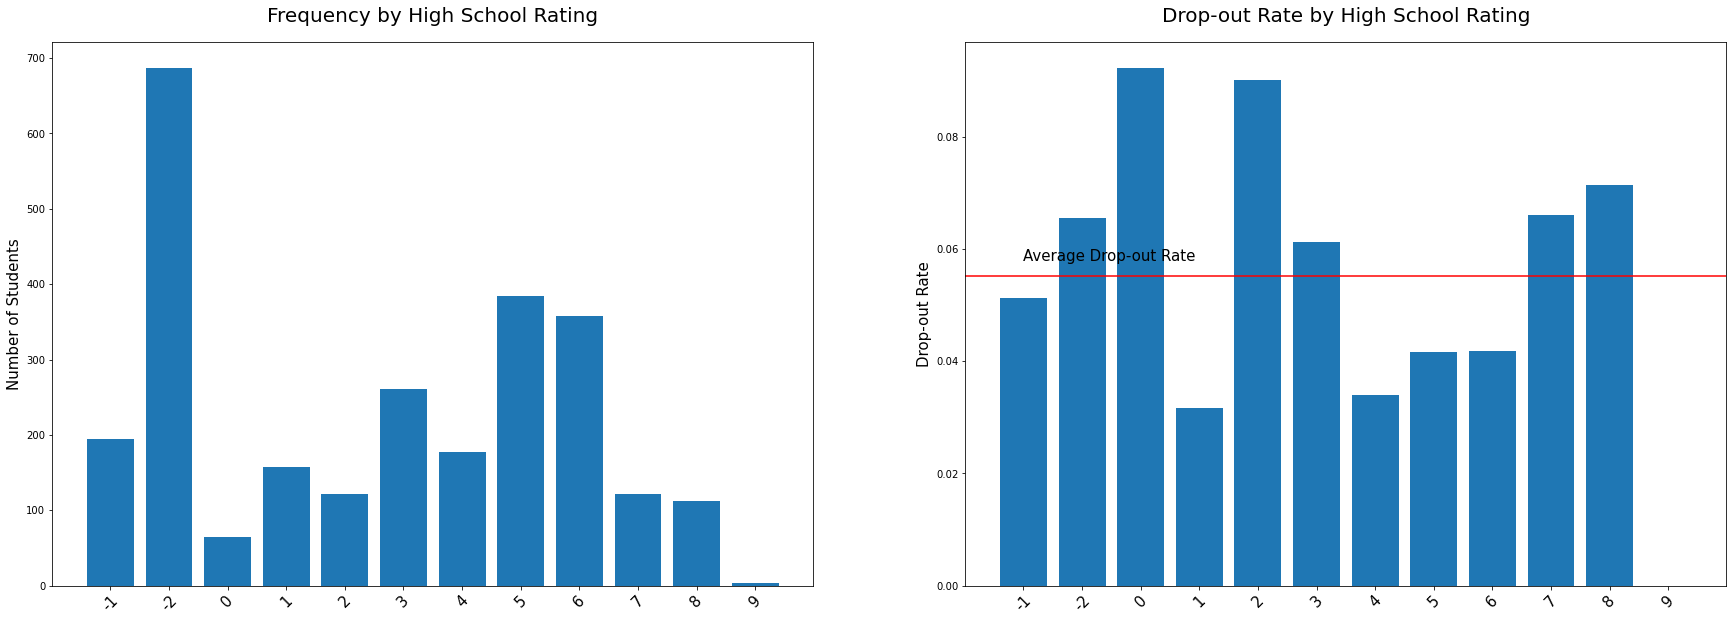

In [21]:
dfHSRatingCount = pd.DataFrame(df.groupby("HSRating")['persistIndicator'].agg('count')).reset_index()
dfHSRatingAvg = pd.DataFrame(df.groupby("HSRating")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfHSRatingCount.HSRating,dfHSRatingCount.persistIndicator,"Frequency by High School Rating")
histCatVariablesNonPersistenceRate(1,dfHSRatingAvg.HSRating,dfHSRatingAvg.persistIndicator,"Drop-out Rate by High School Rating")

#### Summary of Findings for <u>High School</u>:
- Rating of the high school does not have any clear relationship with the drop-out rate.
- Students who attended schools with higher ratings do not have lower drop-out rates.
- Majority of the schools in the database do not have a rating. A more thorough analysis could be done to understand the root cause.

<u>Action</u>:

- Drop this variable.

####  'HS Grad Year', 'HS Grad Date' and 'Months Since HS Grad Date'

Check to see if these three columns carry the same information

In [22]:
#Check to see if there is 100% overlap between HS Grad Year and HS Grad Date
pd.pivot_table(df, index= 'HS Grad Year', columns = 'HS Grad Date', aggfunc = 'count')['Updated ID'].replace({np.nan:""})

HS Grad Date,2010-06-01,2011-06-01,2012-06-01,2013-06-01,2014-06-01,2015-06-01,2016-06-01,2017-06-01,2018-06-01,2019-06-01,2020-06-01,2021-06-01
HS Grad Year,,,,,,,,,,,,
2010,74,,,,,,,,,,,
2011,,79,,,,,,,,,,
2012,,,102,,,,,,,,,
2013,,,,191,,,,,,,,
2014,,,,,182,,,,,,,
2015,,,,,,208,,,,,,
2016,,,,,,,226,,,,,
2017,,,,,,,,233,,,,
2018,,,,,,,,,244,,,


All the counts are on the diagonal. These two fields overlap 100%.

In [23]:
#Check to see if there is 100% overlap between HS Date and Months Since HS Grad Date
pd.pivot_table(df, index= 'HS Grad Date', columns = 'Months Since HS Grad Date', aggfunc = 'count')['Updated ID'].replace({np.nan:""})

Months Since HS Grad Date,14,26,38,50,62,74,86,98,110,122,134,146
HS Grad Date,,,,,,,,,,,,
2010-06-01,,,,,,,,,,,,74
2011-06-01,,,,,,,,,,,79,
2012-06-01,,,,,,,,,,102,,
2013-06-01,,,,,,,,,191,,,
2014-06-01,,,,,,,,182,,,,
2015-06-01,,,,,,,208,,,,,
2016-06-01,,,,,,226,,,,,,
2017-06-01,,,,,233,,,,,,,
2018-06-01,,,,244,,,,,,,,


All the counts are on the diagonal. These two fields overlap 100%.

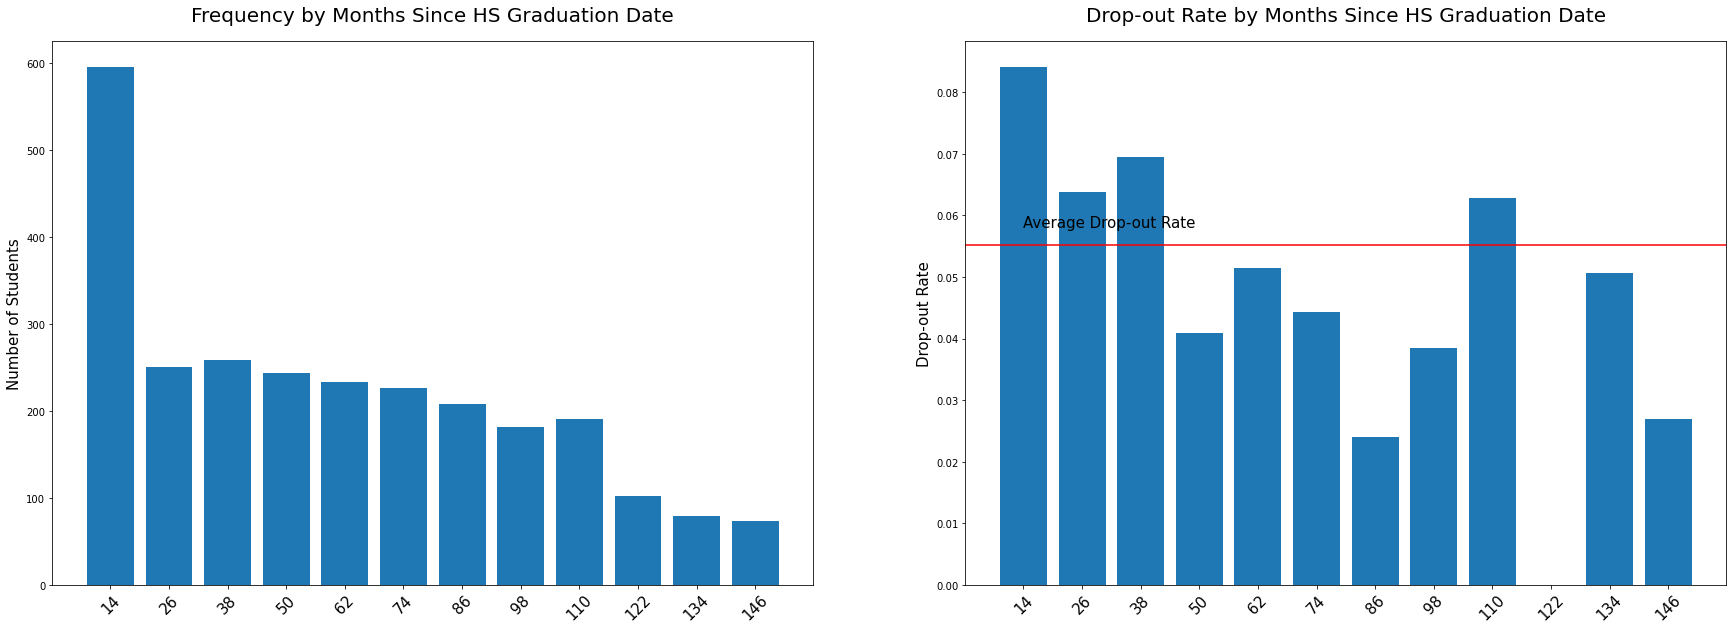

In [24]:
#Check to see trend of the drop-out rate for'Months Since HS Grade Date'
dfMonthsSinceHSCount = pd.DataFrame(df.groupby("Months Since HS Grad Date")['persistIndicator'].agg('count')).reset_index()
dfMonthsSinceHSAvg = pd.DataFrame(df.groupby("Months Since HS Grad Date")['persistIndicator'].agg('mean')).reset_index()

dfMonthsSinceHSCount['Months Since HS Grad Date'] = dfMonthsSinceHSCount['Months Since HS Grad Date'].astype('str')
dfMonthsSinceHSAvg['Months Since HS Grad Date'] = dfMonthsSinceHSAvg['Months Since HS Grad Date'].astype('str')

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfMonthsSinceHSCount['Months Since HS Grad Date'],dfMonthsSinceHSCount.persistIndicator,"Frequency by Months Since HS Graduation Date")
histCatVariablesNonPersistenceRate(1,dfMonthsSinceHSAvg['Months Since HS Grad Date'],dfMonthsSinceHSAvg.persistIndicator,"Drop-out Rate by Months Since HS Graduation Date")

#### Summary of Findings for <u>HS Grad Year</u>, <u>HS Grad Date</u> and <u>Months Since High School Graduation</u> :
- These three variables carry the same information.
- Students who recently graduated from high school tend to have higher drop-out rate.

<u>Action</u>:

- Drop 'HS Grad Year' and 'HS Grad Date'.
- Keep 'Months Since High School Graduation'.

####  'Program Participation'

In [25]:
df['Program Participation'].value_counts(dropna = False)

Scholarship                                  671
Scholarship post 2015                        626
Scholarship post 2015, Institute, Success    518
Scholarship post 2015, Institute             242
Scholarship post 2015, Meritus               206
Success, Scholarship                         178
Meritus-Alumni                                72
Institute, Success, Scholarship               40
Success                                       22
Meritus                                       15
Institute, Scholarship                        14
Institute, Success, Scholarship post 2010     10
ECCA                                           5
Scholarship post 2015, ECCA                    5
Institute                                      5
Scholarship post 2015, Success                 3
Institute, Success                             2
Scholarship post 2015, Meritus-Alumni          1
Institute, Check scholarship                   1
Scholarship, METAS                             1
Scholarship post 201

Below programs are offered by 10,000 Degrees:

| #     | Program |Student Type|Description|
| :---        |    :----   |    :----   |   :----   |
|1|METAS|High school|Program offered by 10,000 Degrees in Marin for students in English as a Second Language (ESL) classes|
|2|ECCA|High school |Program offered by 10,000 Degrees in Marin but not limited to ESL students|
|3|Institute|High school|Program done in summer before the senior year in high school |
|4|Meritus|College|Scholarship and college support from another program that merged with 10,000 Degrees|
|5|Success|College|College support program|
|6|Scholarship|College|Scholarship program|

Some students may have participated to the multiple programs.

In [26]:
#Create a new column for METAS participants
df["METAS"] = df["Program Participation"].map(lambda x: 1 if "METAS" in x else 0)
df["METAS"].value_counts(dropna = False)
df.groupby("METAS")['persistIndicator'].mean()

0    2641
1       3
Name: METAS, dtype: int64

METAS
0    0.055282
1    0.000000
Name: persistIndicator, dtype: float64

In [27]:
#Create a new column for ECCA participants
df["ECCA"] = df["Program Participation"].map(lambda x: 1 if "ECCA" in x else 0)
df["ECCA"].value_counts(dropna = False)
df.groupby("ECCA")['persistIndicator'].mean()

0    2633
1      11
Name: ECCA, dtype: int64

ECCA
0    0.055070
1    0.090909
Name: persistIndicator, dtype: float64

In [28]:
#Create a new column for Institute participants
df["Institute"] = df["Program Participation"].map(lambda x: 1 if "Institute" in x else 0)
df["Institute"].value_counts(dropna = False)
df.groupby("Institute")['persistIndicator'].mean()

0    1810
1     834
Name: Institute, dtype: int64

Institute
0    0.049171
1    0.068345
Name: persistIndicator, dtype: float64

In [29]:
#Create a new column for METAS, ECCA and Institute participants since the counts for METAS and ECCA are low
df['hsProgramParticipant'] = df['METAS'] + df['ECCA'] + df['Institute']
df['hsProgramParticipant'].value_counts(dropna = False)
df.groupby("hsProgramParticipant")['persistIndicator'].mean()

0    1797
1     846
2       1
Name: hsProgramParticipant, dtype: int64

hsProgramParticipant
0    0.048971
1    0.068558
2    0.000000
Name: persistIndicator, dtype: float64

- High school program participants have a higher drop-out rate.
- We will use this variable for model development but we need to understand the reasons behind the high drop-out rate. This variable may be covering some other socio-demographic data related with poverty, etc.

In [30]:
#Create a new column for Meritus participants
df["Meritus"] = df["Program Participation"].map(lambda x: 1 if "Meritus" in x else 0)
df["Meritus"].value_counts(dropna = False)
df.groupby('Meritus')['persistIndicator'].mean()

0    2350
1     294
Name: Meritus, dtype: int64

Meritus
0    0.057021
1    0.040816
Name: persistIndicator, dtype: float64

Meritus participants have a lower drop-out rate.

In [31]:
#Create a new column for Success participants
df["Success"] = df["Program Participation"].map(lambda x: 1 if "Success" in x else 0)
df["Success"].value_counts(dropna = False)
df.groupby('Success')['persistIndicator'].mean()

0    1870
1     774
Name: Success, dtype: int64

Success
0    0.055615
1    0.054264
Name: persistIndicator, dtype: float64

Students in the Success program are less persistent. We need to understand the reason.

In [32]:
#Create a new column for Scholarship participants
df["Scholarship"] = df["Program Participation"].map(lambda x: 1 if "Scholarship" in x else 0)
df["Scholarship"].value_counts(dropna = False)
df.groupby('Scholarship')['persistIndicator'].mean()

1    2521
0     123
Name: Scholarship, dtype: int64

Scholarship
0    0.065041
1    0.054740
Name: persistIndicator, dtype: float64

Students who got a scholarship are more persistent.

In [33]:
#Create a new column for Success, Scholarship and Meritus
df['collegeProgramParticipant'] = df['Meritus'] + df['Success'] + df['Scholarship']
df['collegeProgramParticipant'].value_counts(dropna = False)
df.groupby("collegeProgramParticipant")['persistIndicator'].mean()

1    1675
2     957
0      12
Name: collegeProgramParticipant, dtype: int64

collegeProgramParticipant
0    0.083333
1    0.058507
2    0.049112
Name: persistIndicator, dtype: float64

#### Summary of Findings for <u>Program Participation</u>
- META, ECCA and Institute are all high school programs. The counts for META and ECCA are very low. Participants of these programs have high drop-out rates. This needs to be discussed with 10,000 Degrees.
- Meritus, Success and Scholarship are college programs. Meritus and Scholarship particiants have lower drop-out rates. Success students have high drop-out. This needs to be discussed with 10,000 Degrees.

<u>Action</u>:

- Drop 'Program Participation'
- Keep a new variable hsProgramParticipant for the participants of METAS, ECCA and Institute programs for high school students.
- Keep a new variable for Meritus participants.
- Keep a new variable for Success participants.
- Keep a new variable for Scholarship participants.
- Keep a new variable for collegeProgramParticipant for the particpants of Meritus, Success and Scholarship.

####  'Dual Enrolled'

Students sign up in the community college classes while they are finishing high-school.

In [34]:
df['Dual Enrolled'].value_counts(dropna = False)
df.groupby('Dual Enrolled')['persistIndicator'].mean()

No     2548
Yes      96
Name: Dual Enrolled, dtype: int64

Dual Enrolled
No     0.056122
Yes    0.031250
Name: persistIndicator, dtype: float64

Dual enrolled students are less likely to drop-out.

In [35]:
#Convert to numeric
df['dualEnrolled'] = df["Dual Enrolled"].map(lambda x: 1 if "Yes" in x else 0)
df['dualEnrolled'].value_counts()

0    2548
1      96
Name: dualEnrolled, dtype: int64

#### Summary of Findings for <u>Dual Enrolled</u>
- Students who enrolled to community college during their high school years are more likely to persist in the second year of college.

<u>Action</u>:

- Replace 'Dual Enrolled' with the numeric dualEnrolled variable to be used in development.

####  'Gender'

In [36]:
df['Gender'].value_counts(dropna = False)
df.groupby('Gender')['persistIndicator'].mean()

Female          1717
Male             891
Not Provided      20
Non-binary        16
Name: Gender, dtype: int64

Gender
Female          0.054164
Male            0.056117
Non-binary      0.125000
Not Provided    0.050000
Name: persistIndicator, dtype: float64

In [37]:
#Convert to numeric, Female -> 0, Male -> 1, Non-binary -> 1, Not Provided -> 1 (Non-binary and Not Provided are a very small group. Grouped them with Male with high drop-out rate.)
df['sex'] = df["Gender"].map(lambda x: 0 if "Female" in x else 1)
df['sex'].value_counts()

0    1717
1     927
Name: sex, dtype: int64

#### Summary of Findings for <u>Gender</u>
- Female students are less likely to drop out of college.

<u>Action</u>:

- Replace 'Gender' with the numeric 'sex' variable to be used in development.

#### '% of scholarships not accepted'

In [38]:
df['% of scholarships not accepted'].value_counts(dropna = False)

0%       1271
NaN       589
-50%      148
-100%      64
-25%       61
         ... 
-58%        1
-69%        1
-68%        1
-83%        1
-47%        1
Name: % of scholarships not accepted, Length: 73, dtype: int64

In [39]:
#Create a new column with numeric values for '% of scholarships not accepted' by stripping "%"
df['percScholarshipNotAccepted'] = pd.to_numeric(df['% of scholarships not accepted'].str.strip("%"))

In [40]:
#Create a new variable for percentage of scholarships accepted, all null values were set to a special value of -1
df['percScholarshipAccepted'] =  df['percScholarshipNotAccepted'].map(lambda x: -1 if pd.isnull(x) else 100 + x)
df['percScholarshipAccepted'].head()

0     63.0
1    100.0
2     25.0
3     65.0
4      0.0
Name: percScholarshipAccepted, dtype: float64

In [41]:
#Create a binned variable for the percentage of scholarship accepted
percBinning = [-1,0,10,20,30,40,50,60,70,80,90,100,float("inf")]
df["percScholarshipAcceptedBinned"] = pd.cut(x = df["percScholarshipAccepted"], right = False, bins = percBinning)

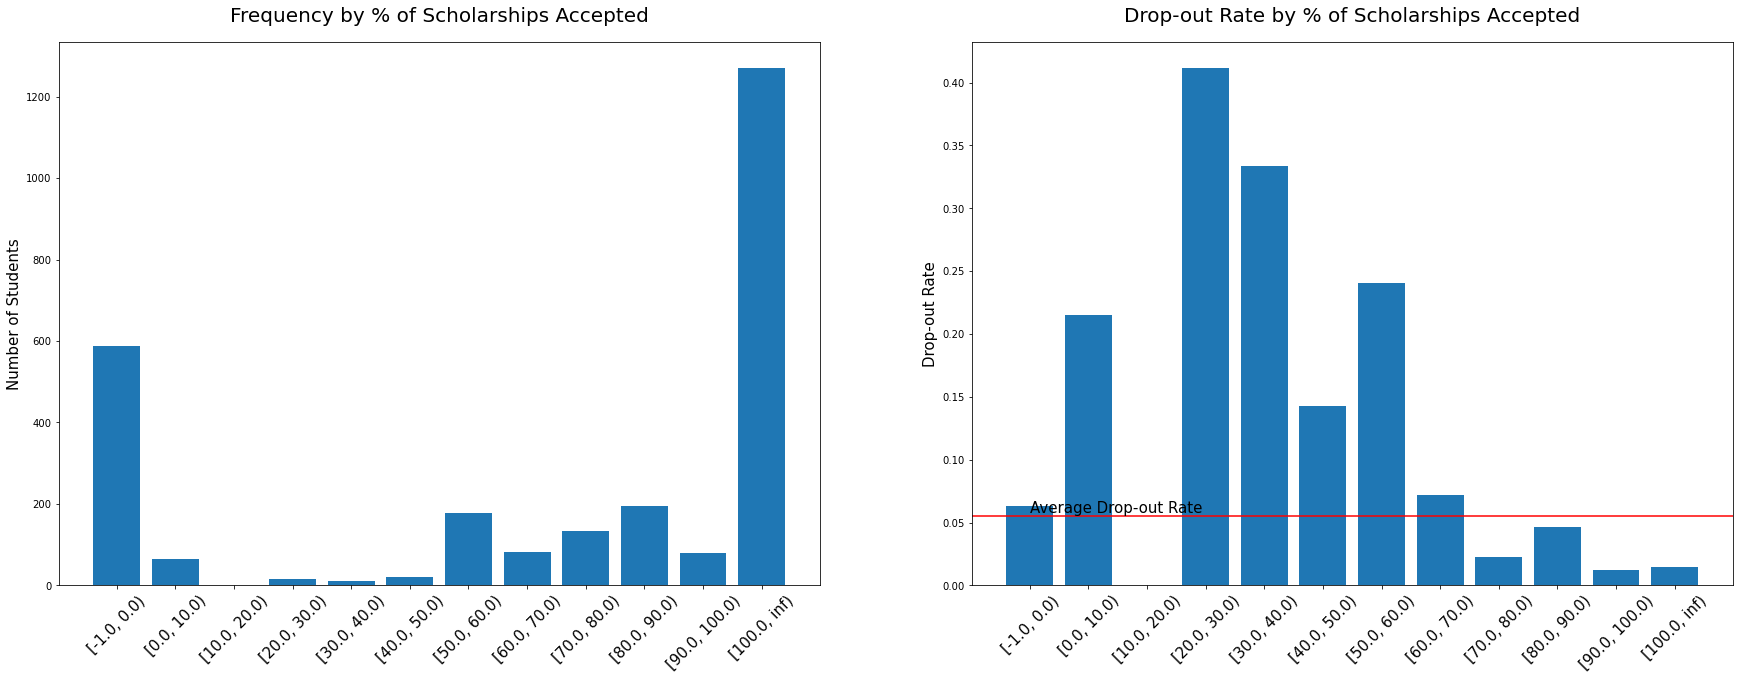

In [42]:
percScholarshipCount = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('count')).reset_index()
percScholarshipAvg = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('mean')).reset_index()

percScholarshipCount['percScholarshipAcceptedBinned'] = percScholarshipCount['percScholarshipAcceptedBinned'].astype(str)
percScholarshipAvg['percScholarshipAcceptedBinned'] = percScholarshipAvg['percScholarshipAcceptedBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,percScholarshipCount['percScholarshipAcceptedBinned'], percScholarshipCount.persistIndicator,"Frequency by % of Scholarships Accepted")
histCatVariablesNonPersistenceRate(1,percScholarshipAvg['percScholarshipAcceptedBinned'],percScholarshipAvg.persistIndicator,"Drop-out Rate by % of Scholarships Accepted")

In [43]:
#Decided to assign missing values (-1) to 70% so that the drop-out rate rank orders with this group included
df['percScholarshipAcceptedTemp'] =  df['percScholarshipAccepted'] #This new variable will be used to calculate the correlation of this variable with the '# of scholarships since 2015'
df['percScholarshipAccepted'] =  df['percScholarshipAccepted'].map(lambda x: 70 if x == -1 else x)

In [44]:
percBinning = [0,10,20,30,40,50,60,70,80,90,100,float("inf")]
df["percScholarshipAcceptedBinned"] = pd.cut(x = df["percScholarshipAccepted"], right = False, bins = percBinning)

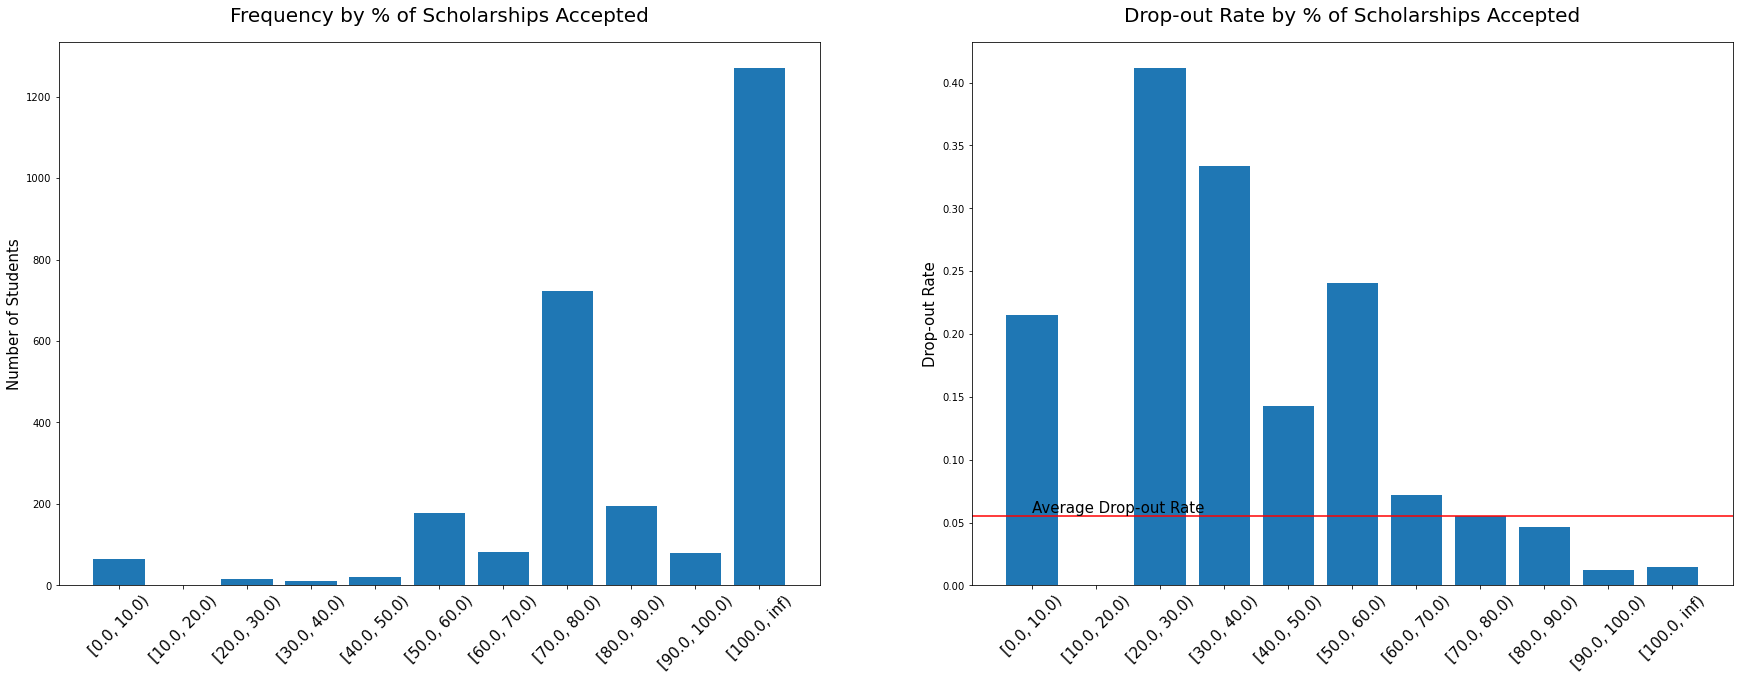

In [45]:
#Scholarship
percScholarshipCount = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('count')).reset_index()
percScholarshipAvg = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('mean')).reset_index()

percScholarshipCount['percScholarshipAcceptedBinned'] = percScholarshipCount['percScholarshipAcceptedBinned'].astype(str)
percScholarshipAvg['percScholarshipAcceptedBinned'] = percScholarshipAvg['percScholarshipAcceptedBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,percScholarshipCount['percScholarshipAcceptedBinned'], percScholarshipCount.persistIndicator,"Frequency by % of Scholarships Accepted")
histCatVariablesNonPersistenceRate(1,percScholarshipAvg['percScholarshipAcceptedBinned'],percScholarshipAvg.persistIndicator,"Drop-out Rate by % of Scholarships Accepted")

#### Summary of Findings for <u>% of scholarships not accepted</u>
- Students who accepted a larger percentage of their scholarship are more likely to persist.

<u>Action</u>:

- Drop '% of scholarships not accepted' and replace it with 'percScholarshipAccepted' to be used in development.

####  'Race/Ethnicity'

In [46]:
df['Race Ethnicity'].value_counts(dropna = False)

Hispanic/Latino/a/x                                     1438
Asian                                                    388
White                                                    287
Black/African American                                   192
Not Provided                                             169
Multiracial/Multiethnic                                  104
Not listed /prefer to self-describe                       49
Pacific Islander                                           9
American Indian/Indigenous American or Alaska Native       8
Name: Race Ethnicity, dtype: int64

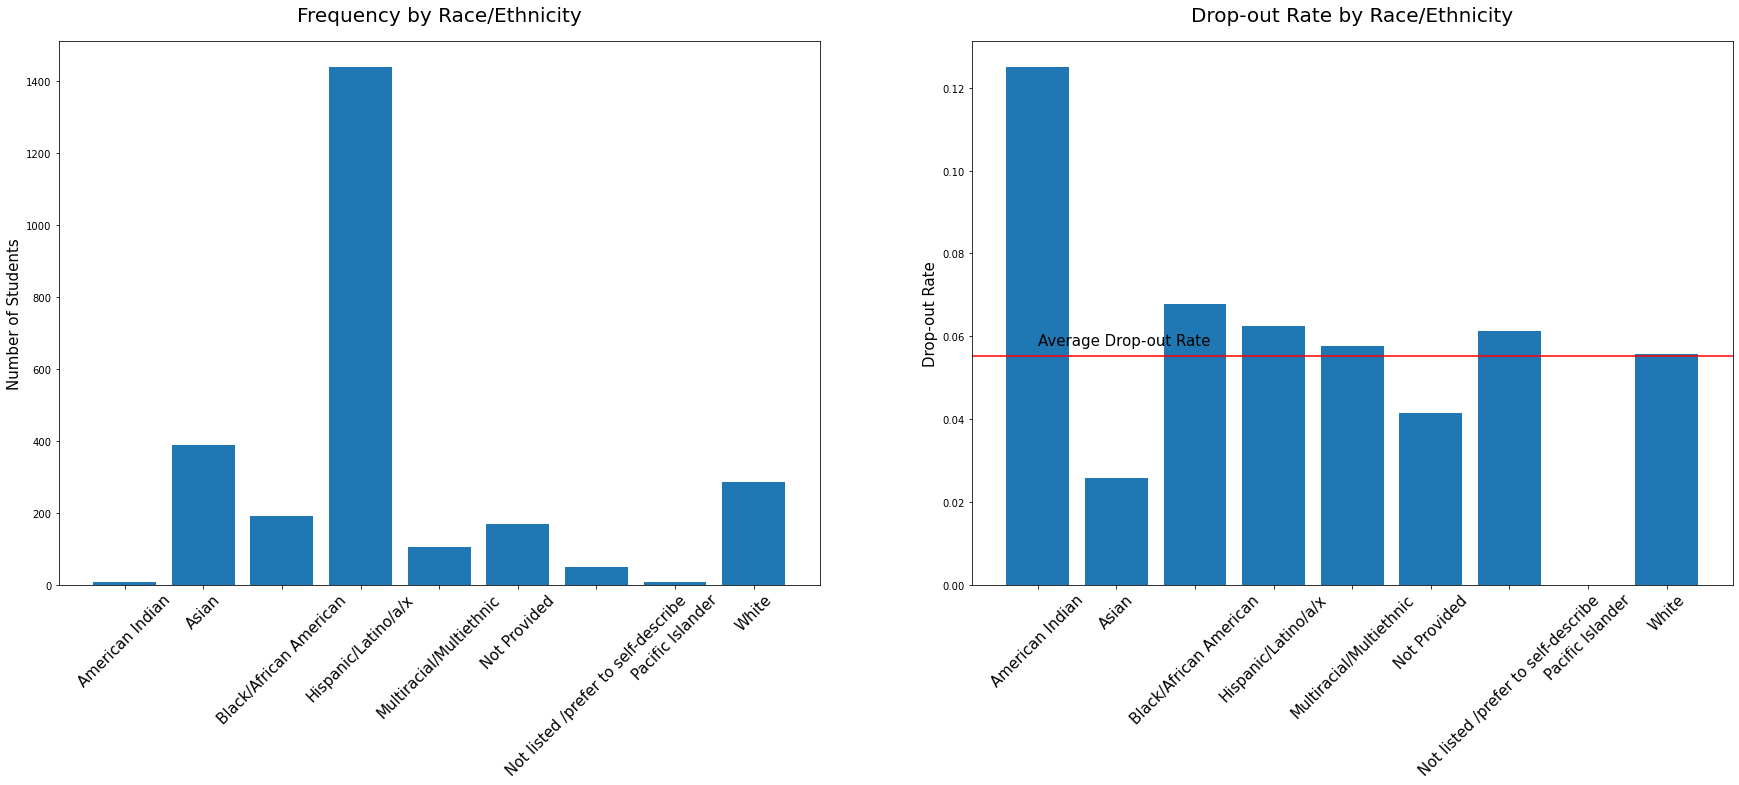

In [47]:
dfRaceCount = pd.DataFrame(df.groupby("Race Ethnicity")['persistIndicator'].agg('count')).reset_index()
dfRaceAvg = pd.DataFrame(df.groupby("Race Ethnicity")['persistIndicator'].agg('mean')).reset_index()

dfRaceCount['Race Ethnicity'] = dfRaceCount['Race Ethnicity'].map(lambda x: 'American Indian' if "American Indian/Indigenous American or Alaska" in x else x)
dfRaceAvg['Race Ethnicity'] = dfRaceAvg['Race Ethnicity'].map(lambda x: 'American Indian' if "American Indian/Indigenous American or Alaska" in x else x)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfRaceCount['Race Ethnicity'],dfRaceCount.persistIndicator,"Frequency by Race/Ethnicity")
histCatVariablesNonPersistenceRate(1,dfRaceAvg['Race Ethnicity'],dfRaceAvg.persistIndicator,"Drop-out Rate by Race/Ethnicity")

In [48]:
#Group race/ethnicity for Hispanic, Asian, White, Black, Other and Not Provided
raceDict = {'Hispanic/Latino/a/x':'Hispanic',
            'Asian':'Asian',
            'White':'White',
            'Black/African American':'Black',
            'Not Provided': 'Not Provided',
            'Multiracial/Multiethnic':'Other',
            'Not listed /prefer to self-describe':'Not Provided',
            'American Indian/Indigenous American or Alaska Native':'Other',
            'Pacific Islander':'Other'}

df['race'] =df['Race Ethnicity'].map(raceDict)
df['race'].value_counts()

Hispanic        1438
Asian            388
White            287
Not Provided     218
Black            192
Other            121
Name: race, dtype: int64

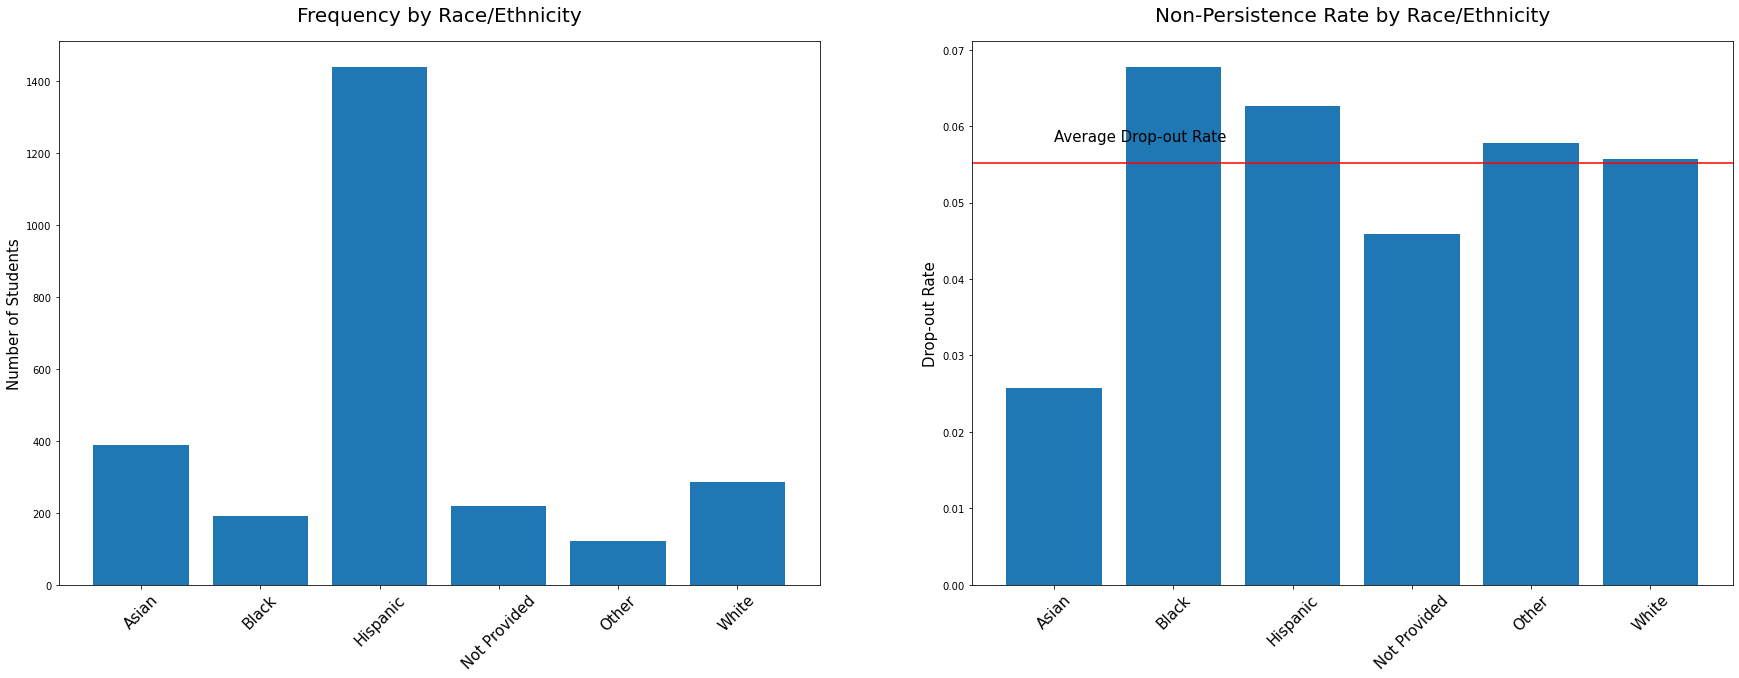

In [49]:
dfRaceCount = pd.DataFrame(df.groupby("race")['persistIndicator'].agg('count')).reset_index()
dfRaceAvg = pd.DataFrame(df.groupby("race")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfRaceCount['race'],dfRaceCount.persistIndicator,"Frequency by Race/Ethnicity")
histCatVariablesNonPersistenceRate(1,dfRaceAvg['race'],dfRaceAvg.persistIndicator,"Non-Persistence Rate by Race/Ethnicity")

In [50]:
#Map race to numeric values based on their drop-out rate
raceDict = {'Black':1,
            'Hispanic':2,
            'Other':3,
            'White':4,
            'Not Provided':5,
            'Asian':6}

df['race'] = df['race'].map(raceDict)
df['race'].value_counts()

2    1438
6     388
4     287
5     218
1     192
3     121
Name: race, dtype: int64

#### Summary of Findings for <u>Race Ethnicity</u>
- Asian and White students are less likely to drop out.

<u>Action</u>:

- Drop 'Race Ethnicity' and replace it with 'race' to be used in development.

####  'Transfer status'

- No -> Still in 2 year
- Transfer -> Transferred to a 4-year college

In [51]:
df['Transfer status'].value_counts(dropna = False)

No    2644
Name: Transfer status, dtype: int64

#### Summary of Findings for <u>Transfer status</u>
- There are no transfer students in the data since the data is for students who attended 4-year colleges.

<u>Action</u>:

- Drop 'Transfer Status'.

####  'HS Region'

In [52]:
df['HS Region'].value_counts(dropna = False)

Marin           949
Sonoma          733
SF Region       555
Other           104
Santa Clara      66
Unknown          55
San Mateo        55
Contra Costa     46
Alameda          29
Utah             28
Napa County      24
Name: HS Region, dtype: int64

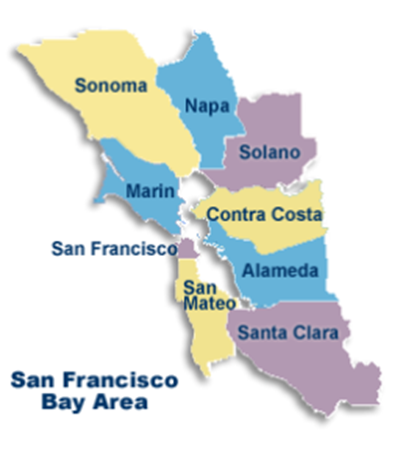

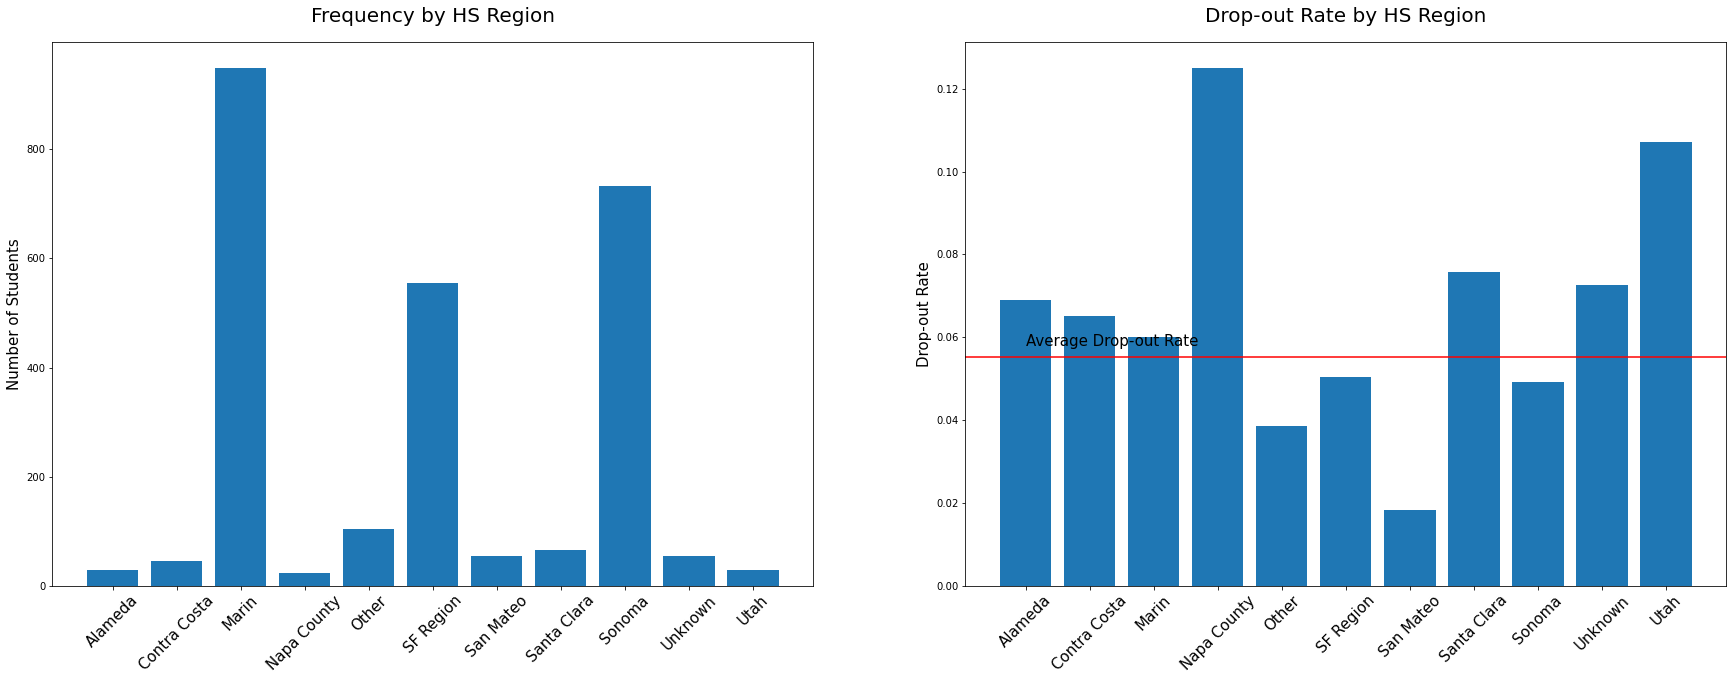

In [53]:
dfHSRegionCount = pd.DataFrame(df.groupby("HS Region")['persistIndicator'].agg('count')).reset_index()
dfHSRegionAvg = pd.DataFrame(df.groupby("HS Region")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfHSRegionCount['HS Region'],dfHSRegionCount.persistIndicator,"Frequency by HS Region")
histCatVariablesNonPersistenceRate(1,dfHSRegionAvg['HS Region'],dfHSRegionAvg.persistIndicator,"Drop-out Rate by HS Region")

In [54]:
dfHSRegionAvg.sort_values(by = 'persistIndicator').rename(columns = {'persistIndicator':'Drop-out Rate'})

,HS Region,Drop-out Rate
6,San Mateo,0.018182
4,Other,0.038462
8,Sonoma,0.049113
5,SF Region,0.050450
2,Marin,0.060063
1,Contra Costa,0.065217
0,Alameda,0.068966
9,Unknown,0.072727
7,Santa Clara,0.075758
10,Utah,0.107143


In [55]:
#Map region to numeric values based on drop-out rate
hsRegionDict = {'San Mateo':1,
                'Other':2,
                'Sonoma':3,
                'SF Region':4,
                'Marin':5,
                'Contra Costa':6,
                'Alameda':7,
                'Unknown':8,
                'Santa Clara':9,
                'Utah':10,
                'Napa County':11}

df['hsRegion'] =df['HS Region'].map(hsRegionDict)

####  '# of scholarships since 2015'

In [56]:
df['# of scholarships since 2015'].value_counts(dropna = False)

NaN    589
1.0    588
4.0    489
2.0    376
3.0    371
5.0    170
6.0     41
7.0     16
8.0      4
Name: # of scholarships since 2015, dtype: int64

In [57]:
df['numScholarships'] = df["# of scholarships since 2015"].fillna(-1)
df['numScholarshipsString'] = df['numScholarships'].astype(str)
df['numScholarshipsString'].value_counts(dropna = False)
df['numScholarships'].value_counts(dropna = False)

-1.0    589
1.0     588
4.0     489
2.0     376
3.0     371
5.0     170
6.0      41
7.0      16
8.0       4
Name: numScholarshipsString, dtype: int64

-1.0    589
 1.0    588
 4.0    489
 2.0    376
 3.0    371
 5.0    170
 6.0     41
 7.0     16
 8.0      4
Name: numScholarships, dtype: int64

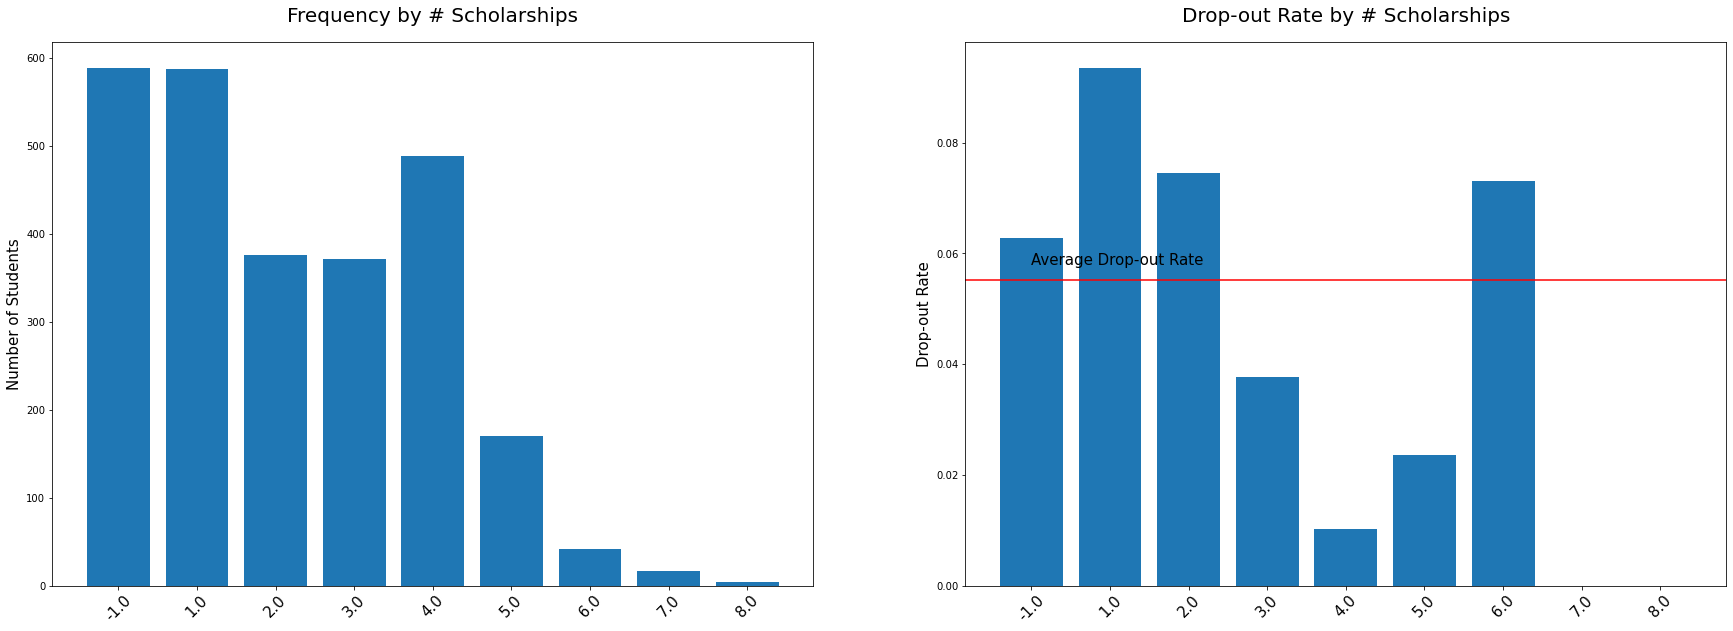

In [58]:
numScholarshipsCount = pd.DataFrame(df.groupby("numScholarshipsString")['persistIndicator'].agg('count')).reset_index()
numScholarshipsAvg = pd.DataFrame(df.groupby("numScholarshipsString")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,numScholarshipsCount['numScholarshipsString'],numScholarshipsCount.persistIndicator,"Frequency by # Scholarships")
histCatVariablesNonPersistenceRate(1,numScholarshipsAvg['numScholarshipsString'],numScholarshipsAvg.persistIndicator,"Drop-out Rate by # Scholarships")

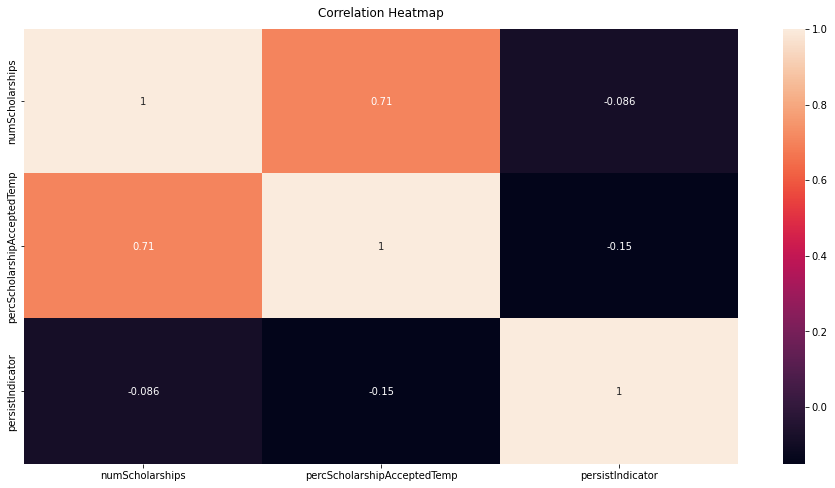

In [59]:
#Review the correlation between 'numScholarships' and 'percScholarshipAccepted'
plt.figure(figsize=(16,8)) 
heatmap = sns.heatmap(df[['numScholarships','percScholarshipAcceptedTemp','persistIndicator']].corr(), annot = True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Summary of Findings for <u># of scholarships since 2015</u>
- A significant percentage of the students do not have this variable populated. Since we are not sure if this means that they didn't get any scholarships, we decided to identify them as a special value with -1.
- Number of scholarships is highly correlated with percentage of scholarship accepted but its correlation with the target is weaker. 

<u>Action</u>:

- Drop '# of scholarships since 2015".

#### 'First College Enrollment Date' and 'Months Until FCE' (FCE = First College Enrollment)

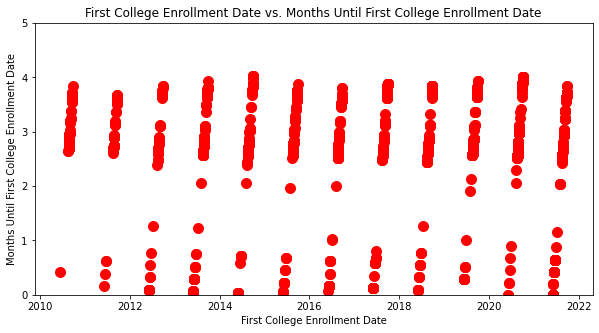

In [60]:
fig, ax = plt.subplots(1, figsize = (10, 5))
plt.title("First College Enrollment Date vs. Months Until First College Enrollment Date")
plt.scatter(df['First College Enrollment Date'], df['Months Until FCE'], s =100, c = 'red')
plt.xlabel("First College Enrollment Date")
plt.ylabel("Months Until First College Enrollment Date")
plt.ylim(0,5);

'Months Until FCE' is 1-5 months for each year since the schools generally close in May-June.

Let's first analyze 'Months Until FCE'.

In [61]:
fceBinning = [0,1,2,3,4,5]
df["fCEBinned"] = pd.cut(x = df["Months Until FCE"], right = False, bins = fceBinning)

df["fCEBinned"].value_counts(dropna = False)

[2, 3)    1723
[3, 4)     623
[0, 1)     266
[4, 5)      23
[1, 2)       9
Name: fCEBinned, dtype: int64

The counts for 1, 3 and 4 months are very low. Decided to apply coarser binning.

In [62]:
fceBinning = [0,2,5]
df["fCEBinned"] = pd.cut(x = df["Months Until FCE"], right = False, bins = fceBinning)

df["fCEBinned"].value_counts(dropna = False)

[2, 5)    2369
[0, 2)     275
Name: fCEBinned, dtype: int64

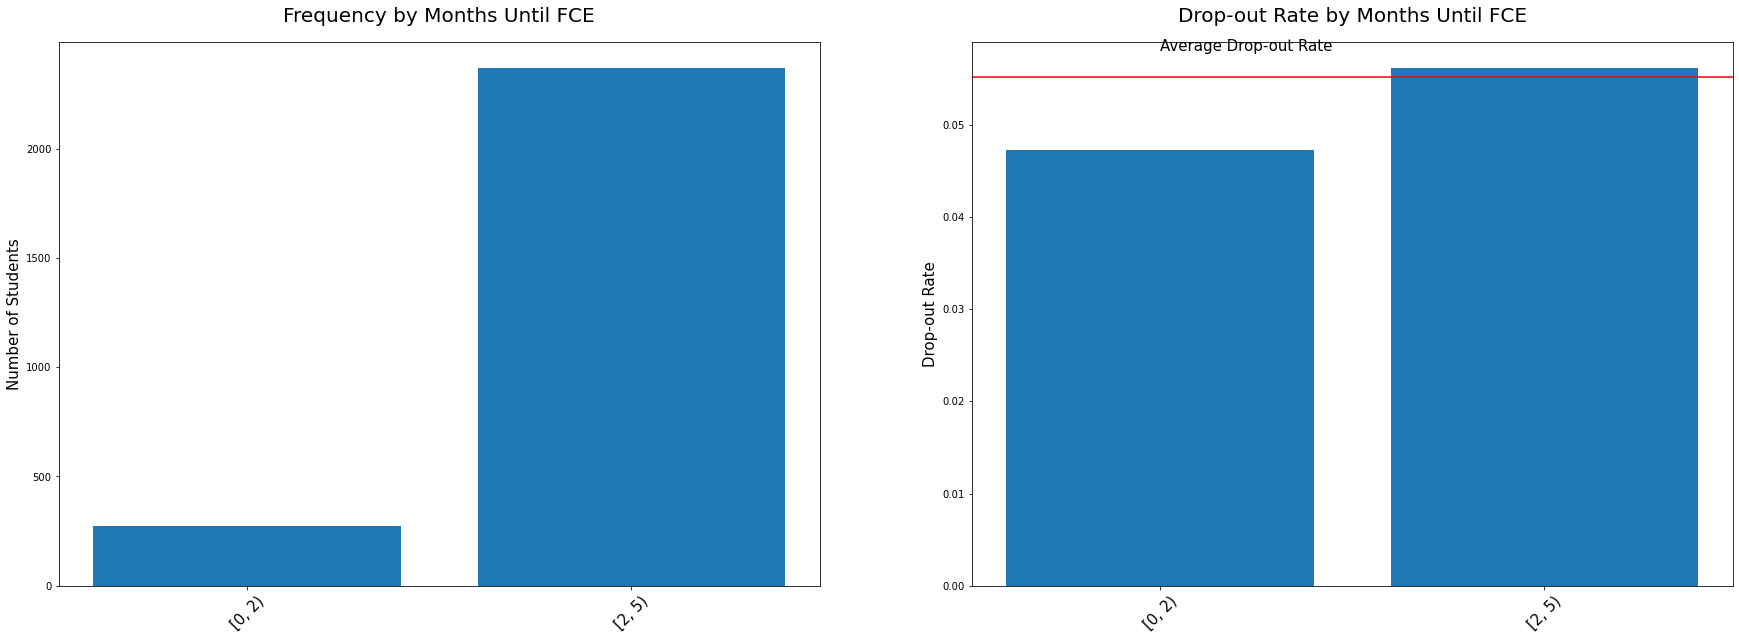

In [63]:
fCECount = pd.DataFrame(df.groupby("fCEBinned")['persistIndicator'].agg('count')).reset_index()
fCEAvg = pd.DataFrame(df.groupby("fCEBinned")['persistIndicator'].agg('mean')).reset_index()

fCECount['fCEBinned'] = fCECount['fCEBinned'].astype(str)
fCEAvg['fCEBinned'] = fCEAvg['fCEBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,fCECount['fCEBinned'],fCECount.persistIndicator,"Frequency by Months Until FCE")
histCatVariablesNonPersistenceRate(1,fCEAvg['fCEBinned'],fCEAvg.persistIndicator,"Drop-out Rate by Months Until FCE")

Let's now analyze First College Enrollment Date

In [64]:
#Convert YYYY-MM-DD into YYYY
df['firstCollegeEnrollmentYear'] = df['First College Enrollment Date'].dt.year

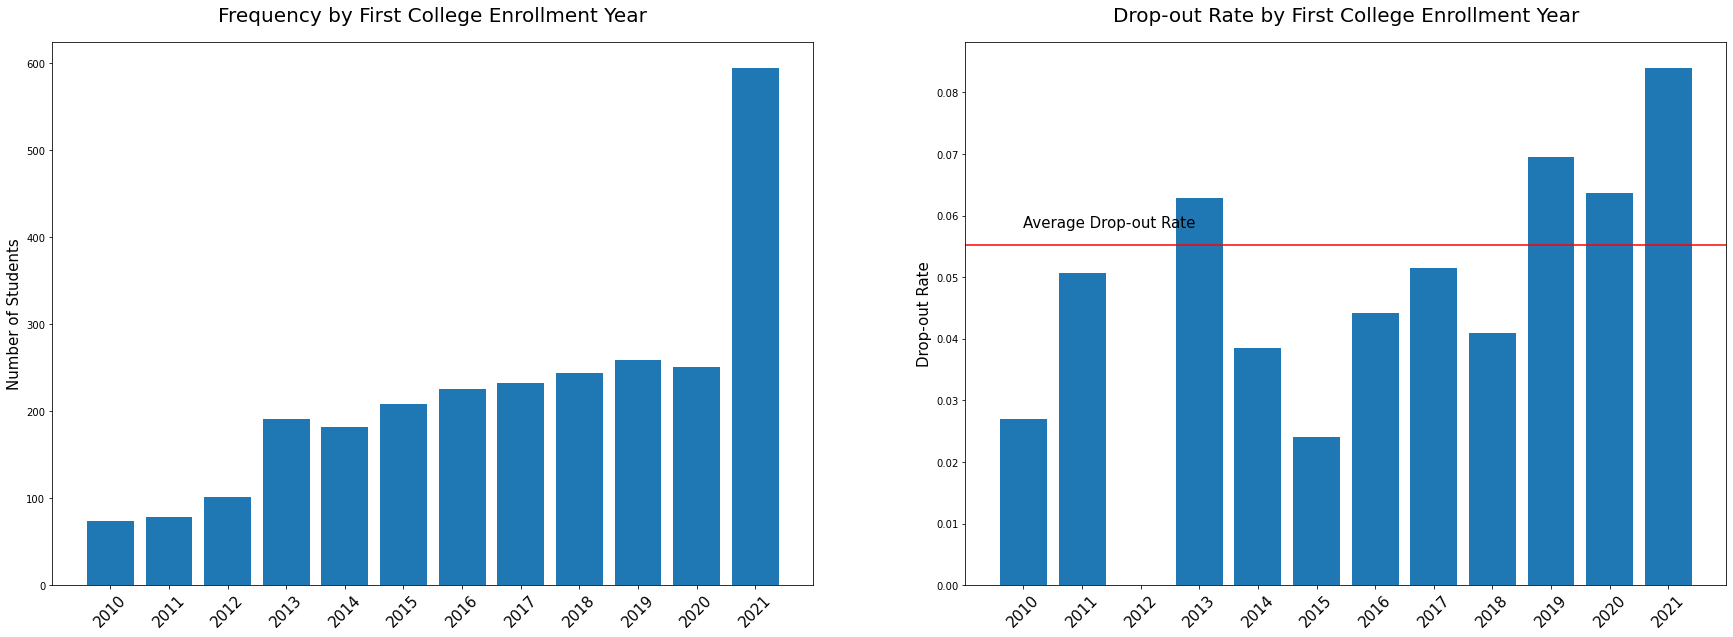

In [65]:
fCEYCount = pd.DataFrame(df.groupby("firstCollegeEnrollmentYear")['persistIndicator'].agg('count')).reset_index()
fCEYAvg = pd.DataFrame(df.groupby("firstCollegeEnrollmentYear")['persistIndicator'].agg('mean')).reset_index()

fCEYCount['firstCollegeEnrollmentYear'] = fCEYCount['firstCollegeEnrollmentYear'].astype(str)
fCEYAvg['firstCollegeEnrollmentYear'] = fCEYAvg['firstCollegeEnrollmentYear'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,fCEYCount['firstCollegeEnrollmentYear'],fCEYCount.persistIndicator,"Frequency by First College Enrollment Year")
histCatVariablesNonPersistenceRate(1,fCEYAvg['firstCollegeEnrollmentYear'],fCEYAvg.persistIndicator,"Drop-out Rate by First College Enrollment Year")

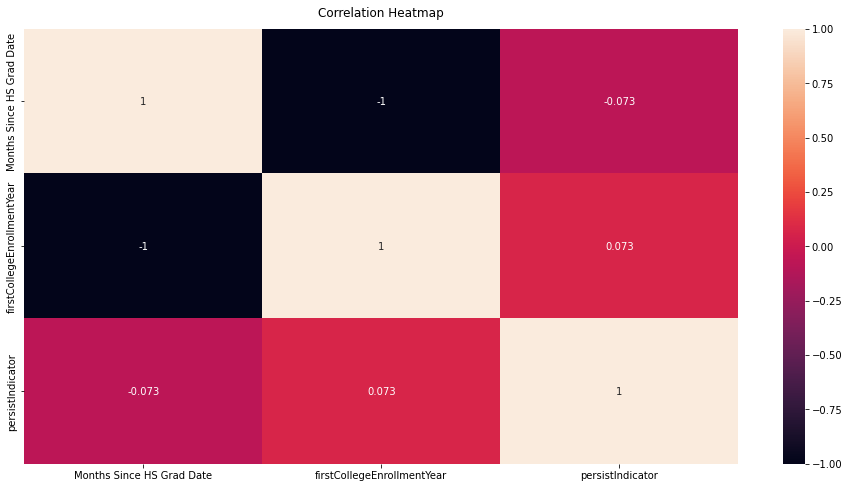

In [66]:
#Review the correlation between 'Months Since HS Grad Date' and 'firstCollegeEnrollmentYear'
plt.figure(figsize=(16,8)) 
heatmap = sns.heatmap(df[['Months Since HS Grad Date','firstCollegeEnrollmentYear','persistIndicator']].corr(), annot = True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Summary of Findings for <u>Months Until FCE</u> and <u>Months Until FCE</u>
- Both 'Months Until FCE' and 'First College Enrollment Date' are correlated with the target.
- However, Months Since HS Grad Date and firstCollegeEnrollmentYear have 100% overlapping information. We can keep only one.

<u>Action</u>:

- Keep 'Months Until FCE' 
- Drop 'First College Enrollment Date'

#### 'First College Name'

In [67]:
df.groupby('First College Name')['persistIndicator'].agg(['count','mean']).sort_values(by = 'count', ascending = False).rename(columns = {"count":"Count","mean":"Drop-out Rate"})

,Count,Drop-out Rate
First College Name,,
Sonoma State University,339,0.085546
San Francisco State University,304,0.078947
California State University - Sacramento,144,0.048611
University Of California-davis,119,0.042017
University Of California-santa Cruz,112,0.035714
...,...,...
Michigan State University,1,0.000000
Morgan State University,1,0.000000
Mount Holyoke College,1,0.000000


#### Summary of Findings for <u>First College Name</u>
- There are 273 different colleges. These colleges can be classified as local vs. in-state vs. out-of-state.

<u>Action</u>:

- Will analyze this variable further during Phase II.

#### 'First College Type'

In [68]:
df['First College Type'].value_counts()

4-Year    2530
2-Year     114
Name: First College Type, dtype: int64

There is no new information in this variable. Will not include it in the development dataset.

#### 'Highest Degree Earned'

In [69]:
df['Highest Degree Earned'].value_counts(dropna = False)

HS             1420
4-Year         1091
Advanced         79
2-Year           31
Certificate      23
Name: Highest Degree Earned, dtype: int64

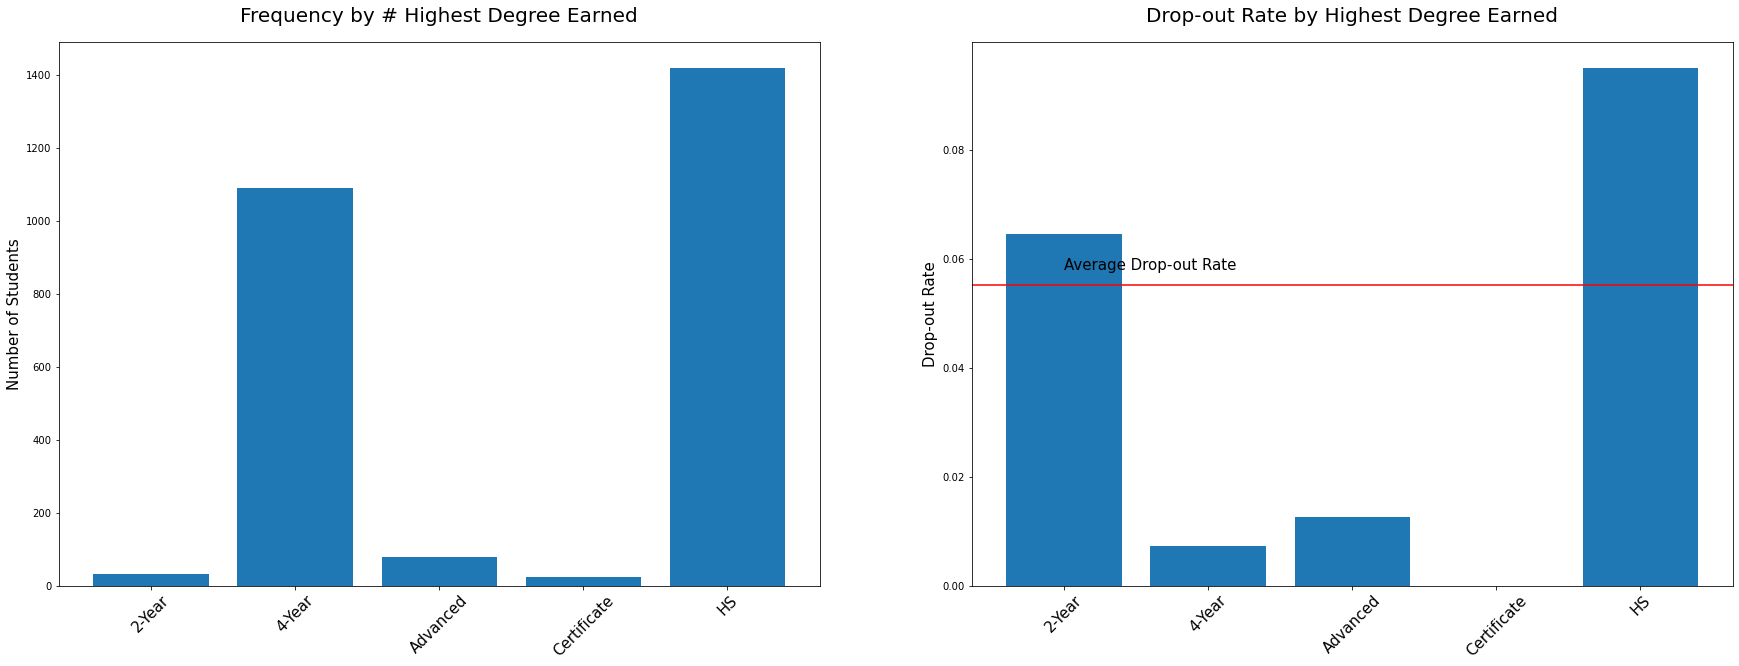

In [70]:
highestDegreeCount = pd.DataFrame(df.groupby("Highest Degree Earned")['persistIndicator'].agg('count')).reset_index()
highestDegreeAvg = pd.DataFrame(df.groupby("Highest Degree Earned")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,highestDegreeCount['Highest Degree Earned'],highestDegreeCount.persistIndicator,"Frequency by # Highest Degree Earned")
histCatVariablesNonPersistenceRate(1,highestDegreeAvg['Highest Degree Earned'],highestDegreeAvg.persistIndicator,"Drop-out Rate by Highest Degree Earned")

In [71]:
#Map highest degree earned to numeric values based on drop-out rate
highestDegreeDict = {'HS':1,
            'Certificate':2,
            '2-Year':3,
            '4-Year':4,
            'Advanced':5}

df['highestDegree'] =df['Highest Degree Earned'].map(highestDegreeDict)

df['highestDegree'].value_counts(dropna = False)

1    1420
4    1091
5      79
3      31
2      23
Name: highestDegree, dtype: int64

#### Summary of Findings for <u>Highest Degree Earned</u>
- Students directly coming from high school are riskier.

<u>Action</u>:

- Replace 'Highest Degree Earned' with the numeric 'highestDegree'

#### Highest Degree College Name

In [72]:
df['Highest Degree College Name'].value_counts(normalize = True,dropna = False)

NaN                                    0.537065
Sonoma State University                0.052194
San Francisco State University         0.040091
University Of California-davis         0.032526
University Of California-santa Cruz    0.020802
                                         ...   
Florida International University       0.000378
Brandeis University                    0.000378
Pennsylvania State University          0.000378
Weber State University                 0.000378
Culinary Institute Of America          0.000378
Name: Highest Degree College Name, Length: 210, dtype: float64

70% is missing. Drop this variable.

#### Development Sample

After discussions with 10,000 Degrees, we agreed to use the following variables for the first phase of the model development effort.

In [73]:
modelingVarList = ['Months Since HS Grad Date',
'hsProgramParticipant',
'Meritus',
'Scholarship',
'Success',
'dualEnrolled',
'sex',
'percScholarshipAccepted',
'race',
'hsRegion',
'Months Until FCE',
'collegeProgramParticipant',
'persistIndicator']

df = df[modelingVarList]
df.head()
df.shape

,Months Since HS Grad Date,hsProgramParticipant,Meritus,Scholarship,Success,dualEnrolled,sex,percScholarshipAccepted,race,hsRegion,Months Until FCE,collegeProgramParticipant,persistIndicator
0,62,0,0,1,0,0,0,63.0,2,5,2.709677,1,0
1,14,1,0,1,0,0,0,100.0,2,3,2.935484,1,0
2,38,0,0,1,0,0,0,25.0,5,5,3.064516,1,1
3,62,1,0,1,1,0,0,65.0,2,5,2.870968,2,0
4,14,0,0,1,0,0,1,0.0,2,4,0.000000,1,0


(2644, 13)

### Step 5: Build a model for 4 Year College Students

In [74]:
#Create a train, test value. Use the default test_size of 25%.
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['persistIndicator']),df['persistIndicator'],random_state = 42, stratify = df['persistIndicator'])

In [75]:
#Confirm the stratification on 'persistIndicator'
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.944528
1    0.055472
Name: persistIndicator, dtype: float64

0    0.945537
1    0.054463
Name: persistIndicator, dtype: float64

#### Build a logistic regression model with default parameters as the baseline

In [76]:
#Scale all the variables
transformer = make_column_transformer((StandardScaler(), list(X_train.columns)),
                                      remainder = 'passthrough' )

In [77]:
#Build a logistic regression pipeline
lgrPipe = Pipeline([('transformer',transformer),
                     ('lgr',LogisticRegression(random_state = 42))]).fit(X_train,y_train)

y_train_predicted = lgrPipe.predict(X_train)
y_test_predicted = lgrPipe.predict(X_test)

y_train_predicted_proba = lgrPipe.predict_proba(X_train)
y_test_predicted_proba = lgrPipe.predict_proba(X_test)

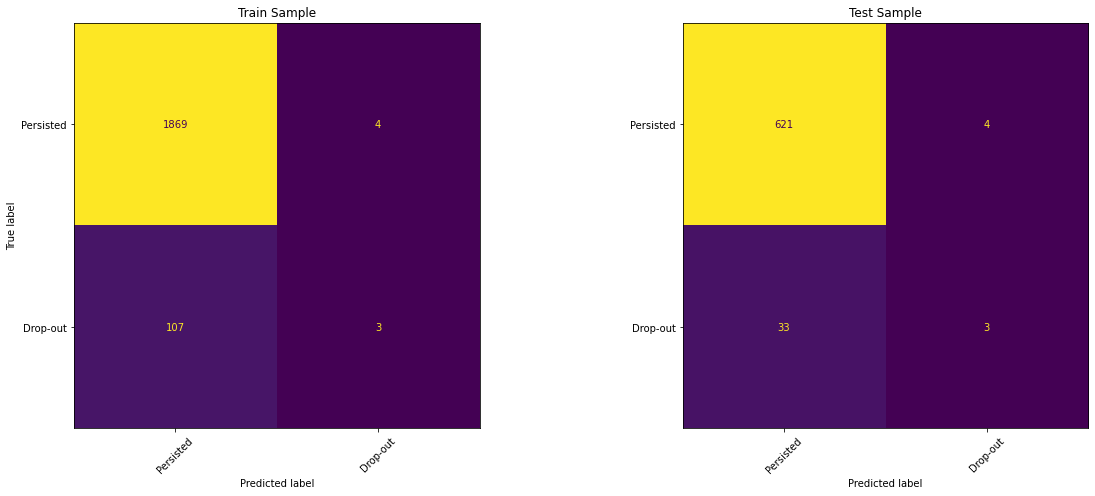

In [78]:
#Display the confusion matrix
dataList = [y_train,y_test]
predictedList = [y_train_predicted, y_test_predicted]
dataLabels = ['Train Sample','Test Sample']

fig, ax = plt.subplots(1,2, figsize = (20,20))
#plt.rcParams.update({'font.size': 20})

for i,j in enumerate(predictedList):
    confusionMatrix= confusion_matrix(dataList[i],j)
    disp = ConfusionMatrixDisplay(confusionMatrix, display_labels = ['Persisted','Drop-out'])
    disp.plot(ax=ax[i], xticks_rotation=45)
    disp.ax_.set_title(dataLabels[i])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')

plt.show();

- In the train sample, there are 107 instances of false negatives (classified as persistent even though a drop-out), or missed opportunities where the necessary interventions were not taken to retain students in college. The test sample reports 33 false negatives.
- Both train and test samples also show 4 false positives, or instances where the investment was misallocated. 
- It is imperative to strive for minimizing both false negatives and false positives in order to maximize success in retaining students and effectively utilizing resources.

In [79]:
#Function to generate summary stats, accuracy, precision, recall, f1-score and AUC
def generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba):
    trainStats = []
    testStats = []
    
    trainStats.append(np.round(accuracy_score(y_train,y_train_predicted),3))
    if (np.sum(y_train_predicted) == 0):
        trainStats.append("N/A")
    else:
        trainStats.append(np.round(precision_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(recall_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(f1_score(y_train,y_train_predicted),3))
    trainStats.append(np.round(roc_auc_score(y_train, y_train_predicted_proba[:,1]),3))
    
    testStats.append(np.round(accuracy_score(y_test,y_test_predicted),3))
    if (np.sum(y_test_predicted) == 0):
        testStats.append("N/A")
    else:
        testStats.append(np.round(precision_score(y_test,y_test_predicted),3))
    testStats.append(np.round(recall_score(y_test,y_test_predicted),3))
    testStats.append(np.round(f1_score(y_test,y_test_predicted),3))
    testStats.append(np.round(roc_auc_score(y_test, y_test_predicted_proba[:,1]),3))
    
    #Summarize results
    listOfStats = ['Accuracy','Precision','Recall','F1 Score','AUC']
    dfStats = pd.DataFrame(zip(listOfStats, trainStats, testStats), columns = ['Metric','Train Sample','Test Sample'])
    return(dfStats)

In [80]:
#Generate summary statistics
generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba)

,Metric,Train Sample,Test Sample
0,Accuracy,0.944,0.944
1,Precision,0.429,0.429
2,Recall,0.027,0.083
3,F1 Score,0.051,0.140
4,AUC,0.804,0.792


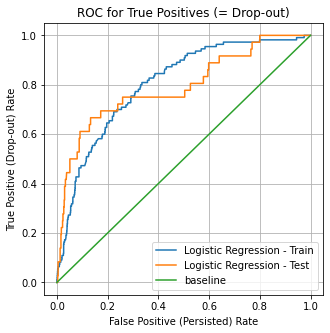

In [81]:
#ROC for the Logistic Regression model with default parameters
fig, ax = plt.subplots(figsize = (5,5))
RocCurveDisplay.from_estimator(lgrPipe, X_train, y_train,ax=ax,label = "Logistic Regression - Train")
RocCurveDisplay.from_estimator(lgrPipe, X_test, y_test,ax=ax,label = "Logistic Regression - Test")
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive (Persisted) Rate')
plt.ylabel('True Positive (Drop-out) Rate')
plt.title('ROC for True Positives (= Drop-out)')
plt.legend()
plt.show();

- Our model's ability to identify students who dropped-out can be analyzed through the above curve.
- Specifically, it predicts more than 60% of the students who dropped-out within the bottom 20% of students who persisted.

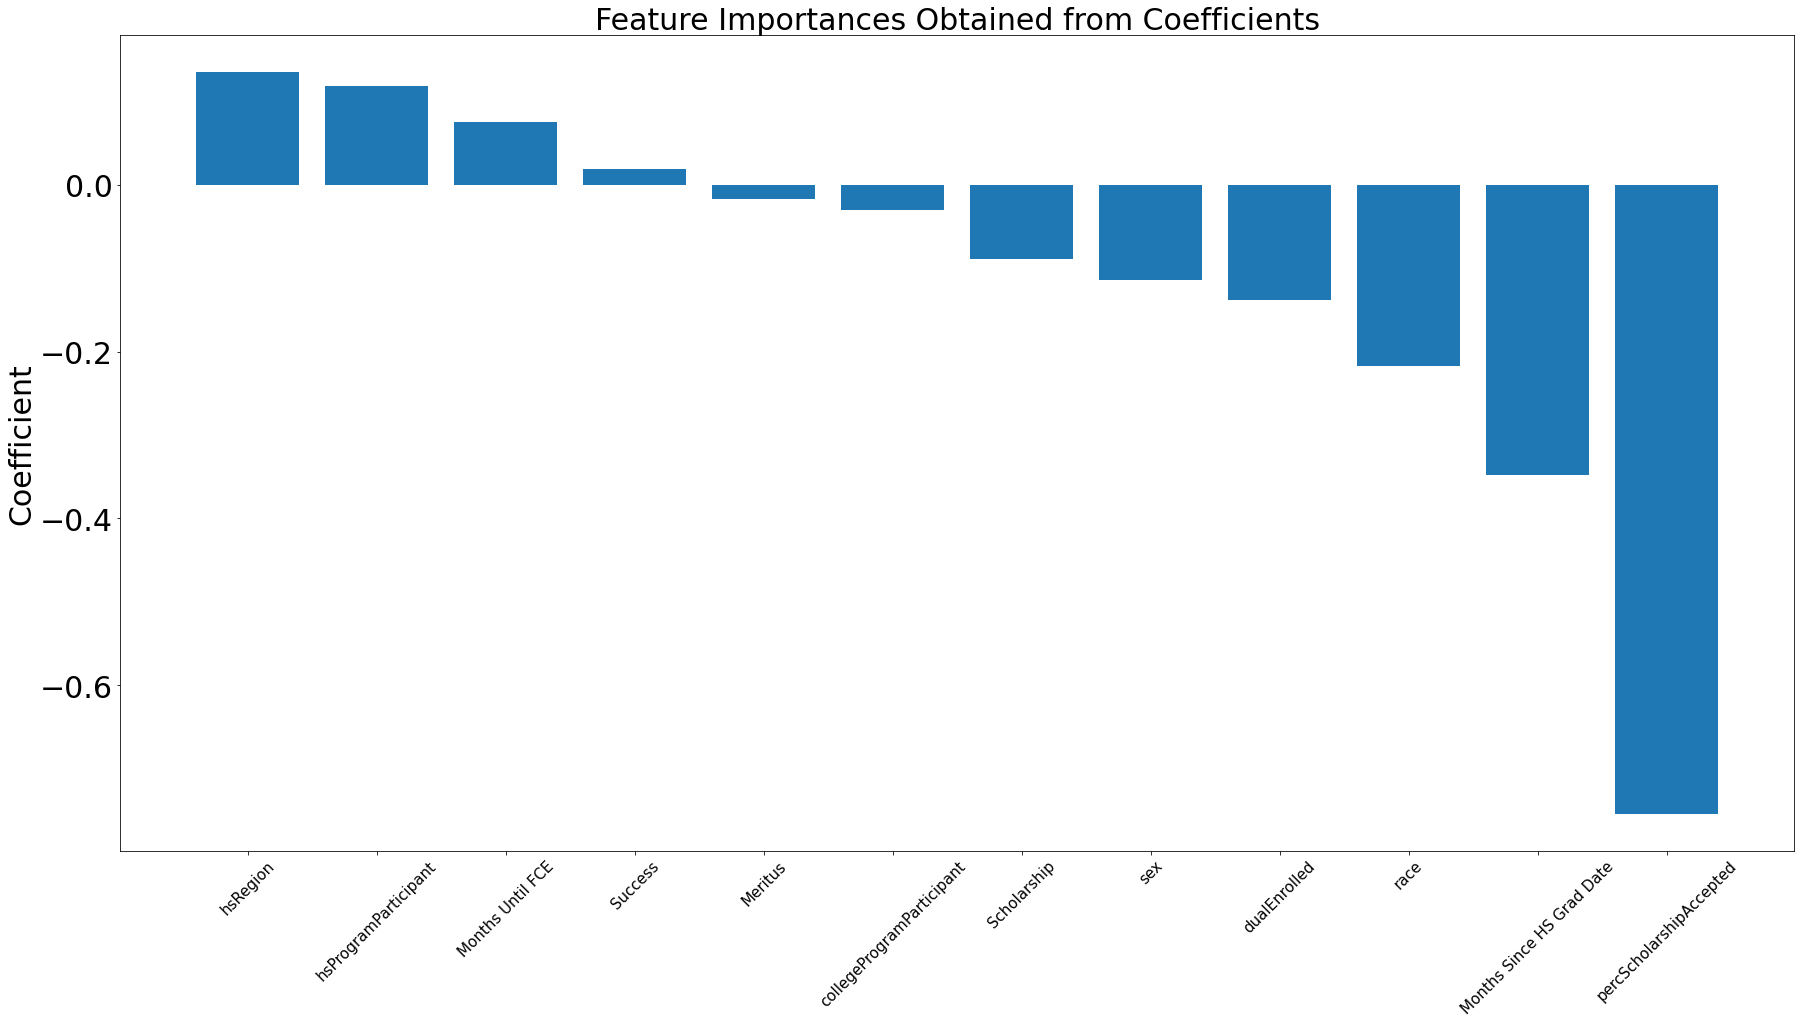

In [82]:
importances = pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': lgrPipe.named_steps["lgr"].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(1, figsize = (30, 15))
ax.bar(x=importances['Feature'], height=importances['Importance'])
ax.set_title('Feature Importances Obtained from Coefficients', size = 30)
ax.set_ylabel('Coefficient', fontsize = 30)
ax.tick_params(axis = 'x',labelrotation=45, labelsize=15)
ax.tick_params(axis = 'y',  labelsize=30)
plt.show();

The following groups of students may have a higher likelihood of dropping out of college:
- Those who did not choose to transfer to a four-year college
- Those with a low rate of scholarship acceptance
- Those who did not take college classes during high school
- Those who did not engage in college programs or activities
- Those residing in specific regions within the Bay Area.

In [83]:
#Get a table of the observed drop-out rate for each decile calculated based on the predicted drop-out rate
y_trainedJoined = pd.DataFrame(y_train).reset_index(drop=True).join(pd.DataFrame(y_train_predicted_proba).reset_index(drop=True)).drop(columns = 0).rename(columns = {1:'dropOutProb'})

label = list(range(1,11,1))
y_trainedJoined['Decile'] = pd.qcut(y_trainedJoined['dropOutProb'],10, label )

#Count of subscribed in each bin
dfTrainSubscribed = pd.DataFrame(y_trainedJoined.groupby('Decile')['persistIndicator'].sum()).reset_index().rename(columns = {"persistIndicator":"Drop-out"})

#Count of records in each bin
dfTrainTotal = pd.DataFrame(y_trainedJoined.groupby('Decile')['persistIndicator'].count()).reset_index().rename(columns = {"persistIndicator":"Total"})

#Generate a dataset with the drop-out rate for each decile
dfTrainStatsLRDefault = pd.merge(dfTrainSubscribed, dfTrainTotal, on = 'Decile')

dfTrainStatsLRDefault['Observed Drop-out Rate'] = dfTrainStatsLRDefault['Drop-out'] / dfTrainStatsLRDefault['Total']
dfTrainStatsLRDefault

,Decile,Drop-out,Total,Observed Drop-out Rate
0,1,2,199,0.010050
1,2,1,198,0.005051
2,3,0,198,0.000000
3,4,3,198,0.015152
4,5,6,199,0.030151
5,6,7,199,0.035176
6,7,12,197,0.060914
7,8,15,198,0.075758
8,9,17,198,0.085859
9,10,47,199,0.236181


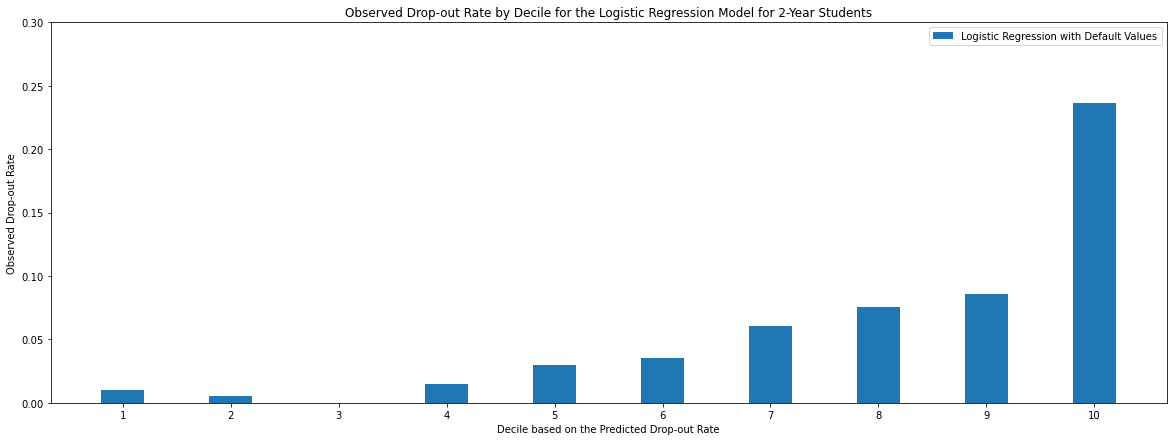

In [84]:
fig,ax = plt.subplots(figsize = (20, 7))

X_label = np.arange(1,11,1)
plt.bar(dfTrainStatsLRDefault['Decile'], dfTrainStatsLRDefault['Observed Drop-out Rate'],width = 0.4, label = 'Logistic Regression with Default Values')
plt.xlabel("Decile based on the Predicted Drop-out Rate")
plt.ylabel("Observed Drop-out Rate")
plt.title("Observed Drop-out Rate by Decile for the Logistic Regression Model for 2-Year Students")

plt.xticks(X_label)
plt.yticks(np.linspace(0,0.3,7))
plt.legend()
plt.show();

- The chart presented above illustrates the ability of the model to rank order students based on their risk of dropping out of college.
- It is evident from the chart that students in the higher deciles have a much greater chance of dropping out, compared to those in the lower deciles.

#### Test other classification algorithms (kNN, Decision Trees and SVC)

In [85]:
#Build K-Nearest Neighbor, logistic regression, decision classifier and SVN models with default parameters
modelList = [KNeighborsClassifier(),
             LogisticRegression(random_state = 42),
             DecisionTreeClassifier(random_state = 42),
             SVC(random_state = 42,probability=True)]

In [86]:
#Train K-Nearest Neighbor, logistic regression, decision classifier and SVN models with default parameters
runTime = []
accuracyScoreTrain = []
accuracyScoreTest = []

precisionScoreTrain = []
precisionScoreTest = []

recallScoreTrain = []
recallScoreTest = []

f1ScoreTrain = []
f1ScoreTest = []

aucScoreTrain = []
aucScoreTest = []

for i in range(len(modelList)):
    t1 = timeit.default_timer()
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    t2 = timeit.default_timer()
    runTime.append(np.round((t2-t1),2))
    
    y_train_predicted = modelPipe.predict(X_train)
    y_test_predicted = modelPipe.predict(X_test)

    y_train_predicted_proba = modelPipe.predict_proba(X_train)
    y_test_predicted_proba = modelPipe.predict_proba(X_test)
    
    accuracyScoreTrain.append(np.round(accuracy_score(y_train, y_train_predicted),3))
    accuracyScoreTest.append(np.round(accuracy_score(y_test, y_test_predicted),3))
    
    precisionScoreTrain.append(np.round(precision_score(y_train, y_train_predicted),3))
    precisionScoreTest.append(np.round(precision_score(y_test, y_test_predicted),3))
    
    recallScoreTrain.append(np.round(recall_score(y_train, y_train_predicted),3))
    recallScoreTest.append(np.round(recall_score(y_test, y_test_predicted),3))
    
    f1ScoreTrain.append(np.round(f1_score(y_train, y_train_predicted),3))
    f1ScoreTest.append(np.round(f1_score(y_test, y_test_predicted),3))
    
    aucScoreTrain.append(np.round(roc_auc_score(y_train, y_train_predicted_proba[:,1]),3))
    aucScoreTest.append(np.round(roc_auc_score(y_test, y_test_predicted_proba[:,1]),3))

In [87]:
#Summarize results
listOfModels = ['kNN','Logistic Regression','Decision Tree','SVM']

dfStats = pd.DataFrame(zip(listOfModels,accuracyScoreTrain, accuracyScoreTest,precisionScoreTrain, precisionScoreTest, recallScoreTrain, recallScoreTest, f1ScoreTrain, f1ScoreTest, aucScoreTrain, aucScoreTest), 
                       columns = ['Model','Train Accuracy','Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall','Test Recall','F1-Score Train','F1-Score Test','Train AUC','Test AUC'])

dfStats

,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,F1-Score Train,F1-Score Test,Train AUC,Test AUC
0,kNN,0.947,0.944,0.643,0.333,0.082,0.028,0.145,0.051,0.929,0.661
1,Logistic Regression,0.944,0.944,0.429,0.429,0.027,0.083,0.051,0.140,0.804,0.792
2,Decision Tree,0.993,0.888,1.000,0.148,0.873,0.222,0.932,0.178,0.999,0.580
3,SVM,0.945,0.946,0.000,0.000,0.000,0.000,0.000,0.000,0.823,0.583


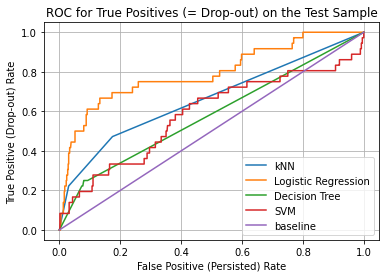

In [88]:
#ROC for kNN, logistic regression and decision tree
labels = ['kNN', 'Logistic Regression', 'Decision Tree', 'SVM']

fig, ax = plt.subplots()

for i in range(len(modelList)):
    modelPipe = Pipeline([('transformer',transformer),
                     ('model',modelList[i])]).fit(X_train,y_train)
    RocCurveDisplay.from_estimator(modelPipe, X_test, y_test,ax=ax,label = labels[i])
    
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.xlabel('False Positive (Persisted) Rate')
plt.ylabel('True Positive (Drop-out) Rate')
plt.title('ROC for True Positives (= Drop-out) on the Test Sample')
plt.legend();

After careful consideration, the following algorithms have been deemed unsuitable for further exploration:
- k-Nearest Neighbors (kNN): Additional features are necessary for the successful implementation of kNN, and it appears to be overfit to the training sample.
- Support Vector Machines (SVM): SVM can be challenging to explain, and explainability is a critical requirement for this particular model.

Given these factors, these algorithms will not be pursued further in the analysis.

#### Further review the decision tree model to minimize overfitting

In [89]:
train_acc = []
test_acc = []

for i in range(1, 11):
    dTree = DecisionTreeClassifier(random_state = 42, max_depth = i).fit(X_train,y_train)
    train_acc.append(dTree.score(X_train,y_train))
    test_acc.append(dTree.score(X_test,y_test))

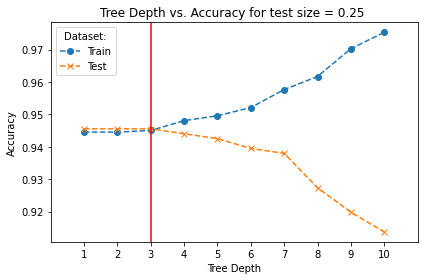

In [90]:
plt.plot(range(1, 11),train_acc , '--o', label = "Train")
plt.plot(range(1, 11),test_acc , '--x', label = "Test")
plt.xlim([0,11])
plt.xticks(range(1, 11))
plt.title('Tree Depth vs. Accuracy for test size = 0.25 ')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(title='Dataset:')
plt.axvline(x = 3, color = 'r', label = 'axvline - full height')
plt.tight_layout();

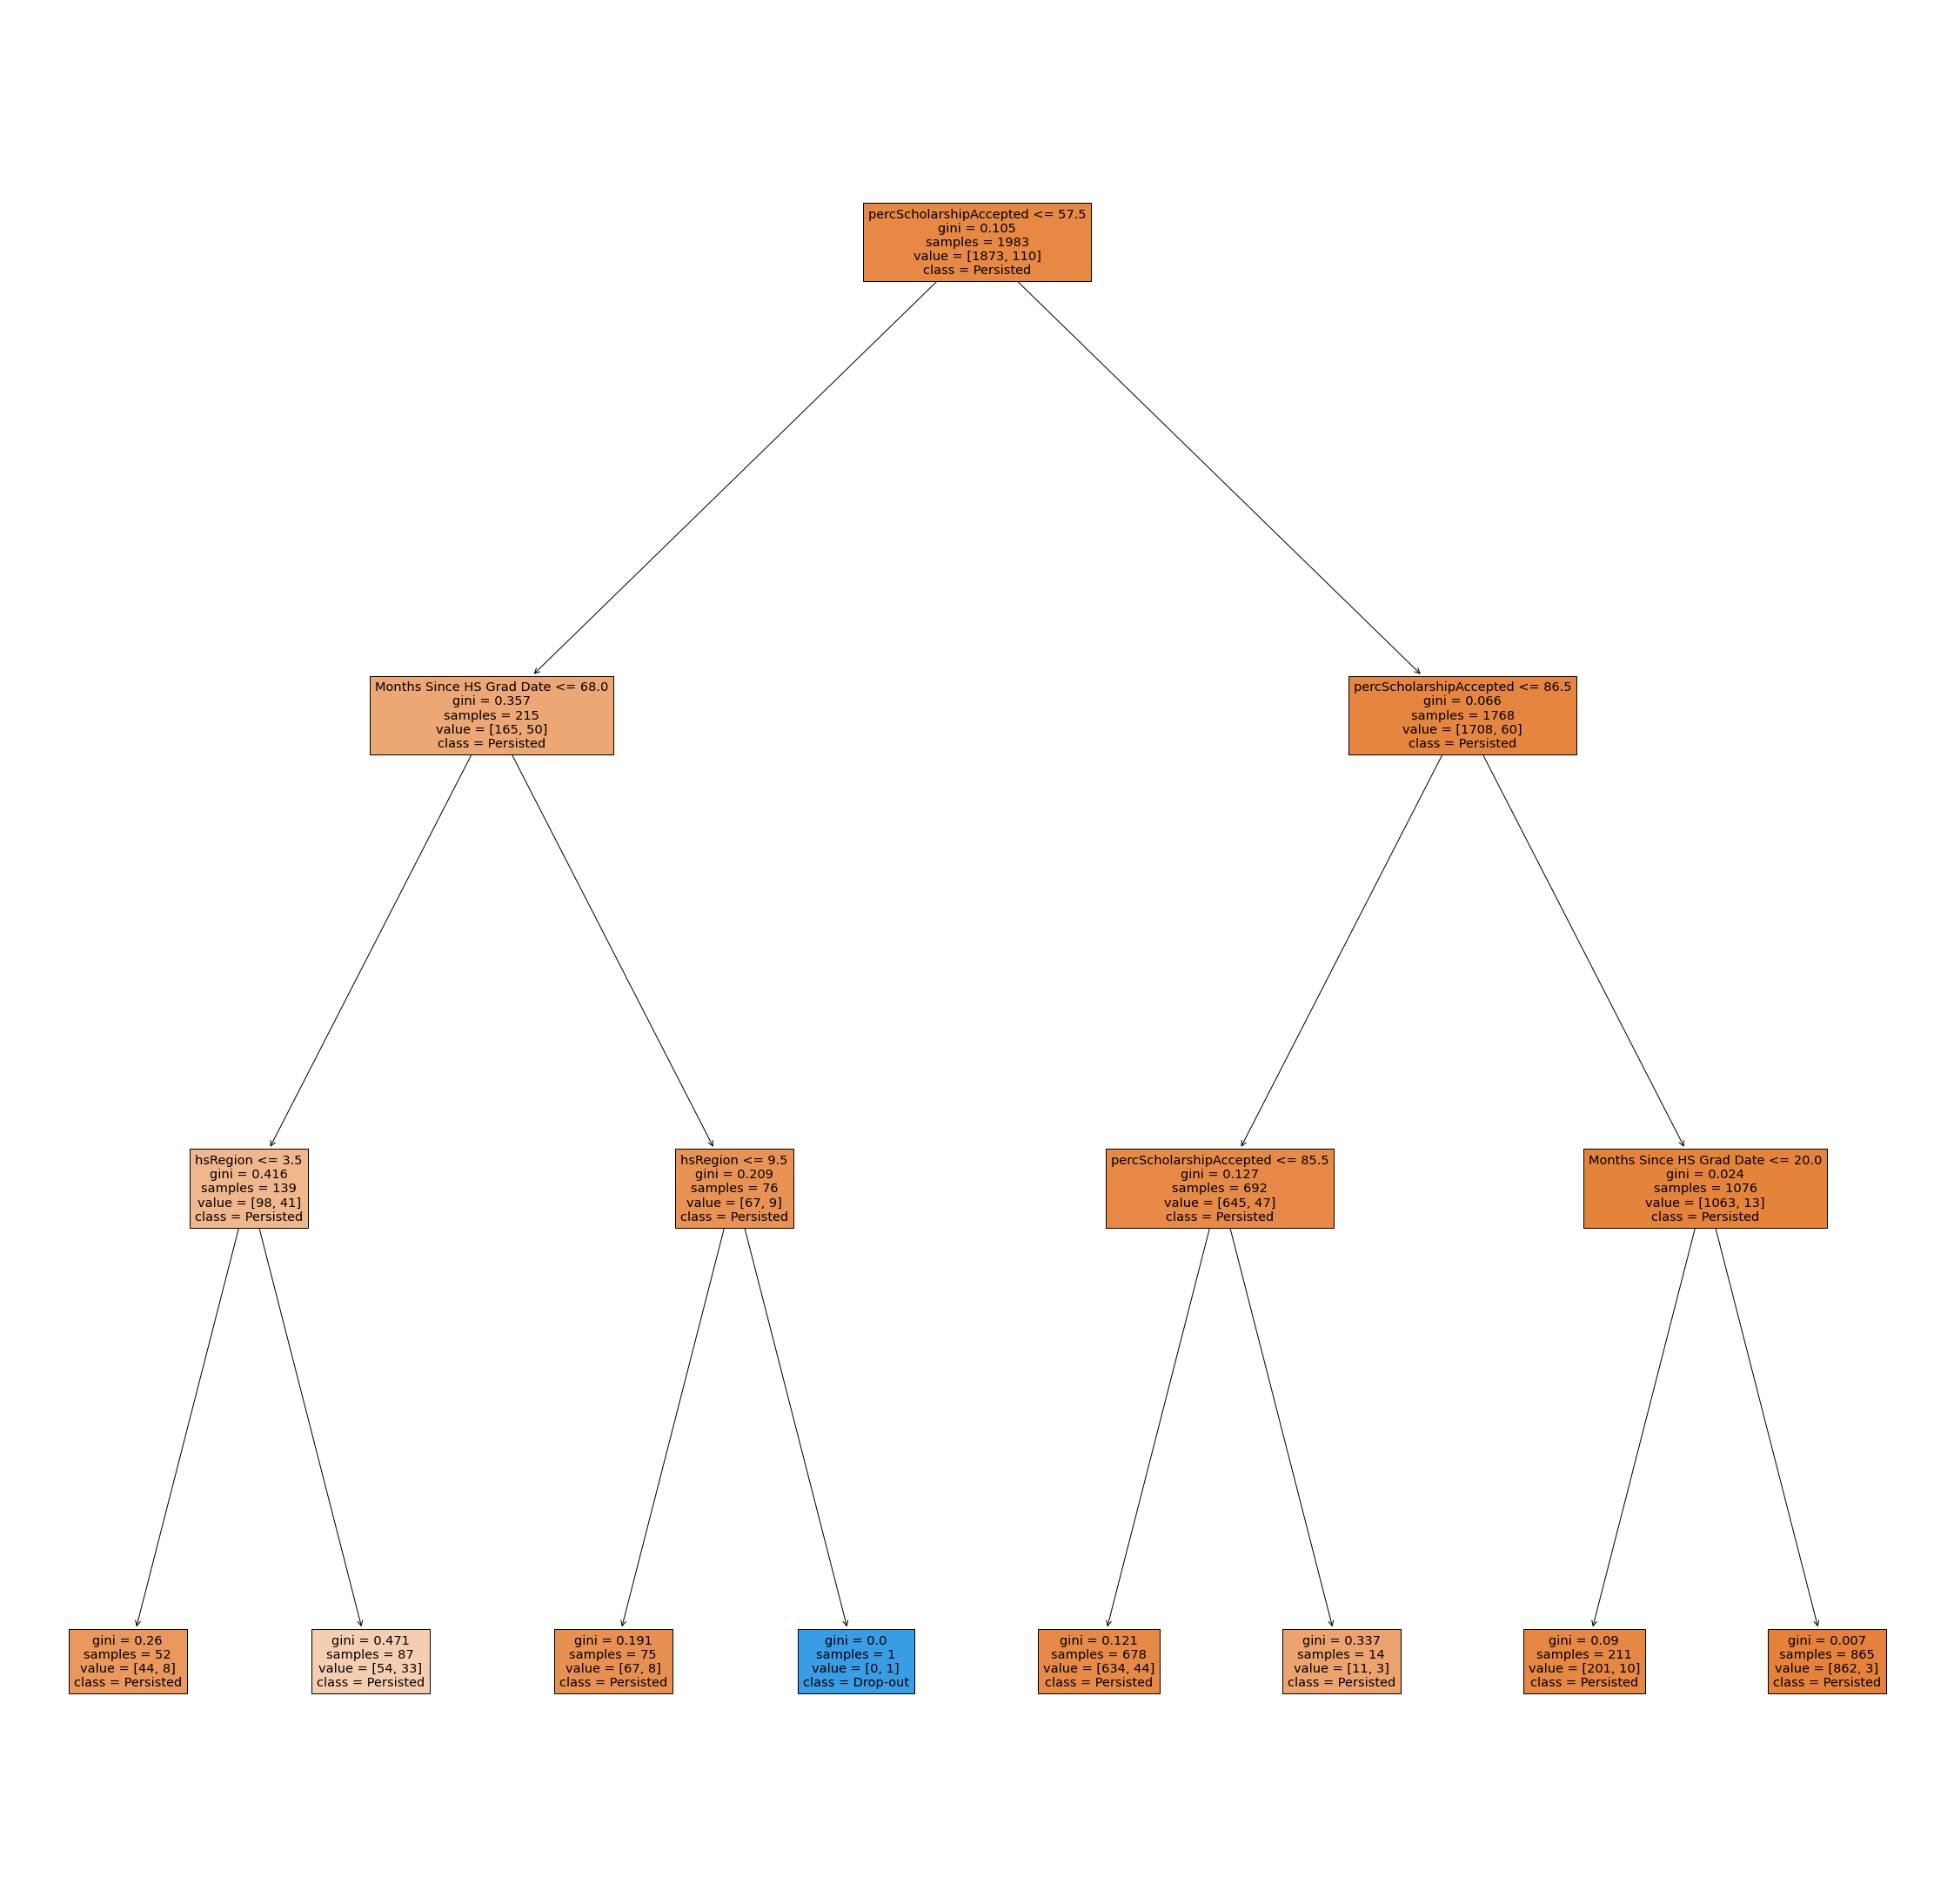

In [91]:
fig, ax = plt.subplots(figsize = (40,40))
tree5 = DecisionTreeClassifier(random_state = 42, max_depth = 3).fit(X_train,y_train)
tree5_plot = plot_tree(tree5,feature_names=list(X_train.columns), filled = True,class_names = ["Persisted","Drop-out"],ax=ax)

#### Further review logistic regression to fit the model with the optimized hyperparameters

In [92]:
#Build a pipeline for grid search on the logistic regression model
extractor = SelectFromModel(LogisticRegression(penalty='l2', solver = 'liblinear' ,random_state = 42))
lgr_pipe = Pipeline([('transformer',transformer),
                     ('selector',extractor),
                     ('lgr',LogisticRegression( solver = 'liblinear',random_state = 42))])

In [93]:
#Test Grid Search for max_features, penalty and C.
roc_grid_lgr = GridSearchCV(lgr_pipe,
                        param_grid= {'selector__max_features':list(range(1,len(X_train.columns)+1)),
                                     'lgr__penalty':['l1','l2'],
                                     'lgr__C': np.logspace(-3, 3, 7, endpoint = True).tolist()}, 
                        scoring = 'roc_auc').fit(X_train, y_train)
roc_grid_lgr.best_params_

{'lgr__C': 0.1, 'lgr__penalty': 'l1', 'selector__max_features': 4}

In [94]:
lgrPipe = Pipeline([
    ('transformer', transformer),
    ('selector', SelectFromModel(LogisticRegression(penalty='l2', solver='liblinear', random_state=42), max_features=roc_grid_lgr.best_params_.get('selector__max_features'))),
    ('lgr', LogisticRegression(penalty=roc_grid_lgr.best_params_.get('lgr__penalty'),
                               C=roc_grid_lgr.best_params_.get('lgr__C'), solver='liblinear', random_state=42))
]).fit(X_train, y_train)


In [95]:
lgr = lgrPipe.named_steps['lgr']
coefficients = lgr.coef_[0]
selector = lgrPipe.named_steps['selector']
features = X_train.columns[selector.get_support()]

coef_df = pd.DataFrame({'feature': features, 'coefficient': coefficients})
coef_df.sort_values(by = 'coefficient')

,feature,coefficient
1,percScholarshipAccepted,-0.640558
0,Months Since HS Grad Date,-0.221542
2,race,-0.091459


The following groups of students may have a higher likelihood of dropping out of college:
- Those with a low rate of scholarship acceptance
- Those who went to high school recently
- Black/African American and Hispanic/Latino/a/x

In [96]:
#Generate summary statistics
generateModelSummaryStats(y_train, y_train_predicted, y_test, y_test_predicted,y_train_predicted_proba,y_test_predicted_proba)

,Metric,Train Sample,Test Sample
0,Accuracy,0.945,0.946
1,Precision,N/A,N/A
2,Recall,0,0
3,F1 Score,0,0
4,AUC,0.823,0.583


In [97]:
#Get a table of the observed drop-out rate for each decile calculated based on the predicted drop-out rate
y_trainedJoined = pd.DataFrame(y_train).reset_index(drop=True).join(pd.DataFrame(y_train_predicted_proba).reset_index(drop=True)).drop(columns = 0).rename(columns = {1:'dropOutProb'})

#label = list(range(1,11,1))
y_trainedJoined['Decile'] = pd.qcut(y_trainedJoined['dropOutProb'],10, label )

#Count of drop-out students in each bin
dfTrainSubscribed = pd.DataFrame(y_trainedJoined.groupby('Decile')['persistIndicator'].sum()).reset_index().rename(columns = {"persistIndicator":"Drop-out"})

#Count of records in each bin
dfTrainTotal = pd.DataFrame(y_trainedJoined.groupby('Decile')['persistIndicator'].count()).reset_index().rename(columns = {"persistIndicator":"Total"})

#Generate a dataset with the drop-out rate for each decile
dfTrainStatsLRHyperP = pd.merge(dfTrainSubscribed, dfTrainTotal, on = 'Decile')

dfTrainStatsLRHyperP['Observed Drop-out Rate'] = dfTrainStatsLRHyperP['Drop-out'] / dfTrainStatsLRHyperP['Total']
dfTrainStatsLRHyperP


,Decile,Drop-out,Total,Observed Drop-out Rate
0,1,0,199,0.000000
1,2,0,198,0.000000
2,3,1,198,0.005051
3,4,2,198,0.010101
4,5,0,199,0.000000
5,6,16,198,0.080808
6,7,18,198,0.090909
7,8,13,198,0.065657
8,9,14,198,0.070707
9,10,46,199,0.231156


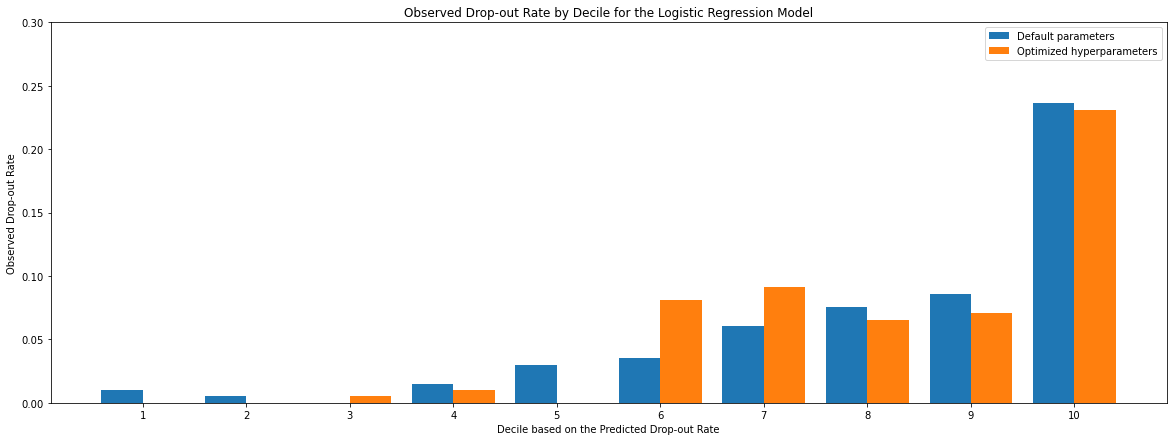

In [98]:
#Generate a chart to observe the rank ordering capability of the model
fig,ax = plt.subplots(figsize = (20, 7))

X_label = np.arange(1,11,1)
plt.bar(X_label - 0.2, dfTrainStatsLRDefault['Observed Drop-out Rate'],width = 0.4,label = 'Default parameters')
plt.bar(X_label + 0.2, dfTrainStatsLRHyperP['Observed Drop-out Rate'], width = 0.4,label = 'Optimized hyperparameters' )
plt.xlabel("Decile based on the Predicted Drop-out Rate")
plt.ylabel("Observed Drop-out Rate")
plt.title("Observed Drop-out Rate by Decile for the Logistic Regression Model")
plt.xticks(X_label)
plt.yticks(np.linspace(0,0.3,7))
plt.legend()
plt.show();

The chart does not show any improvement in the model's capacity to rank order after the optimization of its hyperparameters.We need to review this segment of the population in more detail.